In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import MULTISBM1IMPROVED as model
import logging
import seaborn as sns
from scipy.stats import mode
import random  
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde

# ---------------------------- Fijar Semillas --------------------------------------
np.random.seed(42)
random.seed(42)

# Si usas Pytensor (lo que usa PyMC 4.x internamente)
import pytensor
pytensor.config.default_rng = np.random.default_rng(42)  # Configurar semilla para Pytensor

In [3]:
np.random.seed(42)
random.seed(42)
pytensor.config.default_rng = np.random.default_rng(42)

df = pd.read_csv("SIMULACION2.csv", index_col=0)
data_matrix = df.to_numpy(dtype=int)
data_matrix = np.array(data_matrix, dtype=np.float64)
print(f"Tipo de data_matrix: {data_matrix.dtype}")
print(f"Forma de data_matrix: {data_matrix.shape}")

#---------------------------- Hyperparameters --------------------------------------#
num_blocks = 5
num_supblocks = 3
num_nodes = 100
mu_zeta = 0  
sigma_zeta = 2  
a_tau = 2 
b_tau = 1  
a_alpha = 1
b_alpha = 1
a_sigma = 2
b_sigma = 1 
a_beta = 1
b_beta = 1


Tipo de data_matrix: float64
Forma de data_matrix: (100, 100)


In [4]:
# ---------------------------- Create and Sample Hierarchical Model --------------------------------------
HierarchicalSBM_improved = model.create_model_hierarchical_improved(
    data_matrix, 
    num_nodes=num_nodes, 
    num_blocks=num_blocks,
    num_supblocks=num_supblocks, 
    a_alpha=a_alpha,
    b_alpha=b_alpha,
    a_beta=a_beta,     
    b_beta=b_beta,    
    mu_zeta=mu_zeta,
    sigma_zeta=sigma_zeta,
    a_tau=a_tau,
    b_tau=b_tau,
    a_sigma=a_sigma,  
    b_sigma=b_sigma    
)

with HierarchicalSBM_improved:
    init = 'adapt_diag'
    trace_hier = pm.sample(
        draws=10000,
        tune=10000,
        target_accept=0.95,
        init=init,
        return_inferencedata=True,
        random_seed=42,
        chains=4,
        cores=2,
        idata_kwargs={"log_likelihood": True}
    )


Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [alpha, omega, beta, upsilon, log_tau, log_sigma, zeta_raw, mu_qr_logit, Theta_kl_logit]
>CategoricalGibbsMetropolis: [gamma_row, E_vector]


/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 2465 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# Calcular WAIC directamente del objeto trace que ya tiene la log-verosimilitud
waic_data = az.waic(trace_hier)

# Imprimir el objeto waic_data para ver su estructura
print("WAIC object structure:")
print(waic_data)

# Extraer la log-verosimilitud para calcular AIC y BIC
log_likelihood = trace_hier.log_likelihood.Y_obs.values
log_likelihood_sum = log_likelihood.sum()

# Para el número de parámetros, usamos sizes en lugar de dims para evitar el FutureWarning
n_chains = trace_hier.posterior.sizes["chain"]
n_draws = trace_hier.posterior.sizes["draw"]
k = n_chains * n_draws  # Número de parámetros
n = log_likelihood.shape[0]  # Número de observaciones

# Calcular AIC y BIC
aic = -2 * log_likelihood_sum + 2 * k
bic = -2 * log_likelihood_sum + k * np.log(n)

# Para extraer el valor de WAIC, verificamos la estructura actual
# En versiones recientes de ArviZ, el valor de WAIC está almacenado como 'elpd_waic' con signo negativo
try:
    # Acceder directamente al valor WAIC
    waic_value = -2 * float(waic_data.elpd_waic)
except AttributeError:
    # Si aún no podemos acceder, intentamos inspeccionar el objeto
    print("Available attributes:", dir(waic_data))
    # Como último recurso, podríamos usar el valor directamente
    waic_value = np.nan  # Marcar como no disponible si no podemos extraerlo

# Crear tabla de métricas
metrics_table = pd.DataFrame({
    "WAIC": [waic_value],
    "AIC": [aic], 
    "BIC": [bic]
})

# Mostrar y guardar métricas
print("\nInformation Criteria Metrics:")
print(metrics_table)

##CONVERGENCIA DE LA VEROSIMILITUD

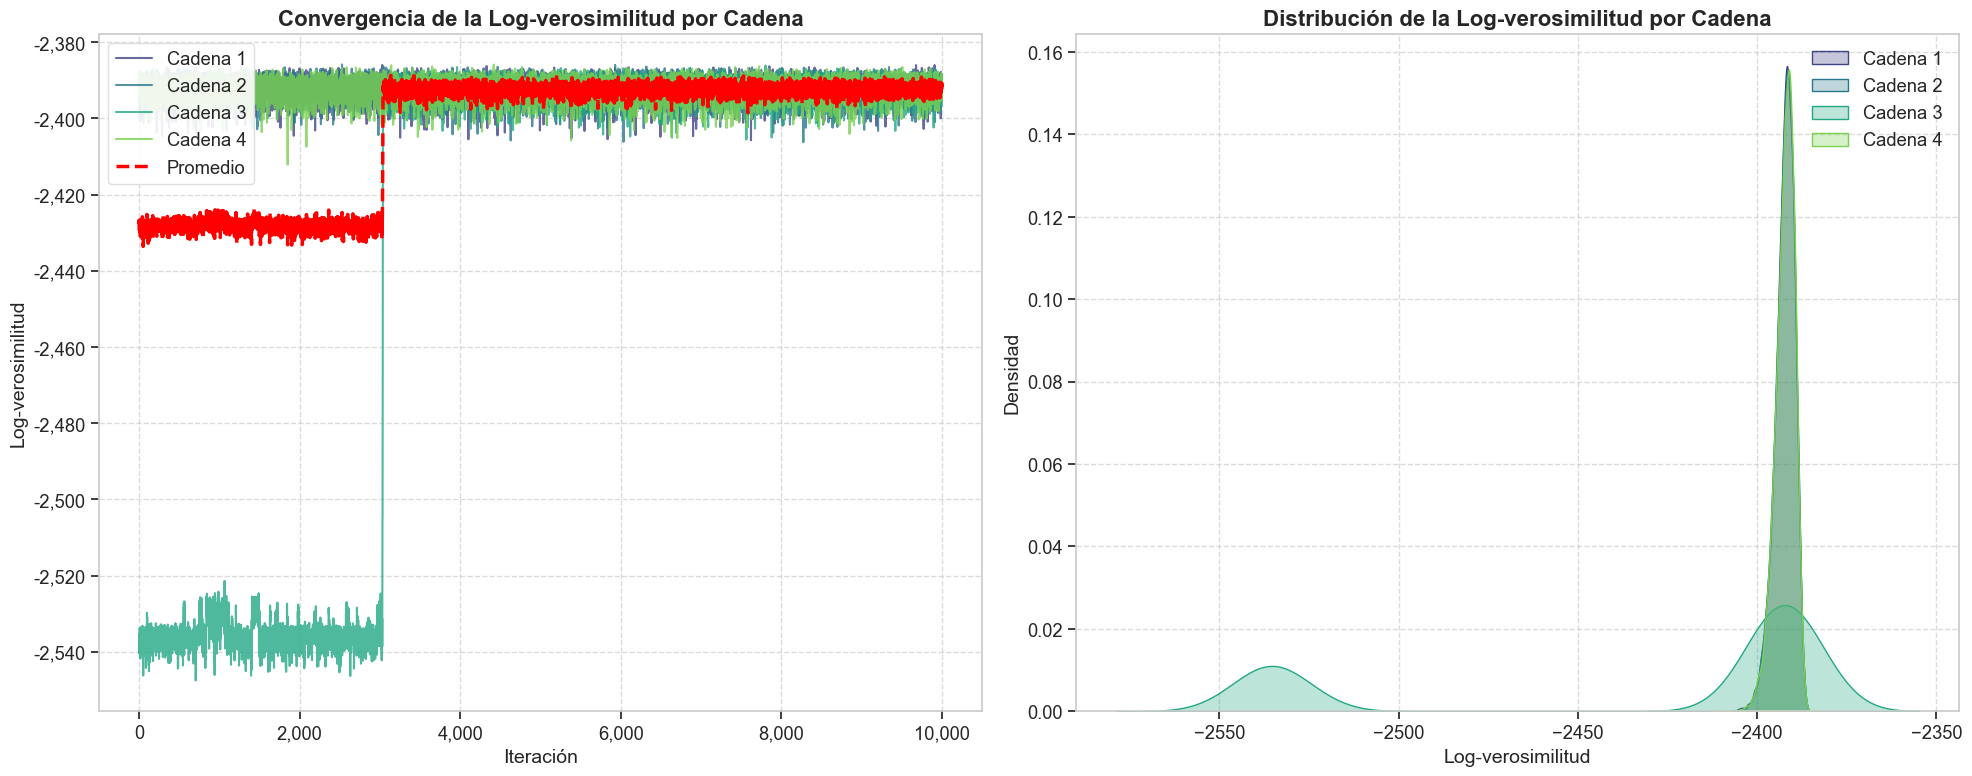

In [6]:
# Configuración estética general
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Extraer los valores del log-likelihood
log_likelihood = trace_hier.log_likelihood["Y_obs"]  # Cambio de trace a trace_hier
log_posterior = log_likelihood.sum(dim="Y_obs_dim_0")
log_posterior_values = log_posterior.values

# Figura combinada: Convergencia y distribución lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Colores para cada cadena en un esquema agradable
colors = sns.color_palette("viridis", log_posterior_values.shape[0])

# GRÁFICO 1: Convergencia por cadena (izquierda)
for chain in range(log_posterior_values.shape[0]):
    axes[0].plot(
        np.arange(log_posterior_values.shape[1]), 
        log_posterior_values[chain], 
        label=f"Cadena {chain+1}",
        color=colors[chain],
        linewidth=1.5,
        alpha=0.8
    )

# Añadir línea de promedio
mean_posterior = np.mean(log_posterior_values, axis=0)
axes[0].plot(
    np.arange(mean_posterior.shape[0]), 
    mean_posterior, 
    label="Promedio",
    color="red",
    linewidth=2.5,
    linestyle="--"
)

# Mejorar ejes y leyendas
axes[0].set_xlabel("Iteración", fontsize=14)
axes[0].set_ylabel("Log-verosimilitud", fontsize=14)
axes[0].set_title("Convergencia de la Log-verosimilitud por Cadena", fontsize=16, fontweight='bold')

# Formatear los ticks con mejor legibilidad
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Añadir un grid sutil
axes[0].grid(True, linestyle='--', alpha=0.7)

# Mejorar la leyenda
axes[0].legend(
    loc='upper left', 
    frameon=True, 
    fancybox=True, 
    framealpha=0.9,
    edgecolor='gainsboro'
)

# GRÁFICO 2: Distribución de densidad (derecha)
for chain in range(log_posterior_values.shape[0]):
    sns.kdeplot(
        log_posterior_values[chain],
        ax=axes[1],
        label=f"Cadena {chain+1}",
        color=colors[chain],
        fill=True,
        alpha=0.3
    )

axes[1].set_xlabel("Log-verosimilitud", fontsize=14)
axes[1].set_ylabel("Densidad", fontsize=14)
axes[1].set_title("Distribución de la Log-verosimilitud por Cadena", fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ajustes finales
plt.tight_layout()
plt.savefig("Log_Posterior_MULTISIM2.png", dpi=300, bbox_inches="tight")
plt.show()

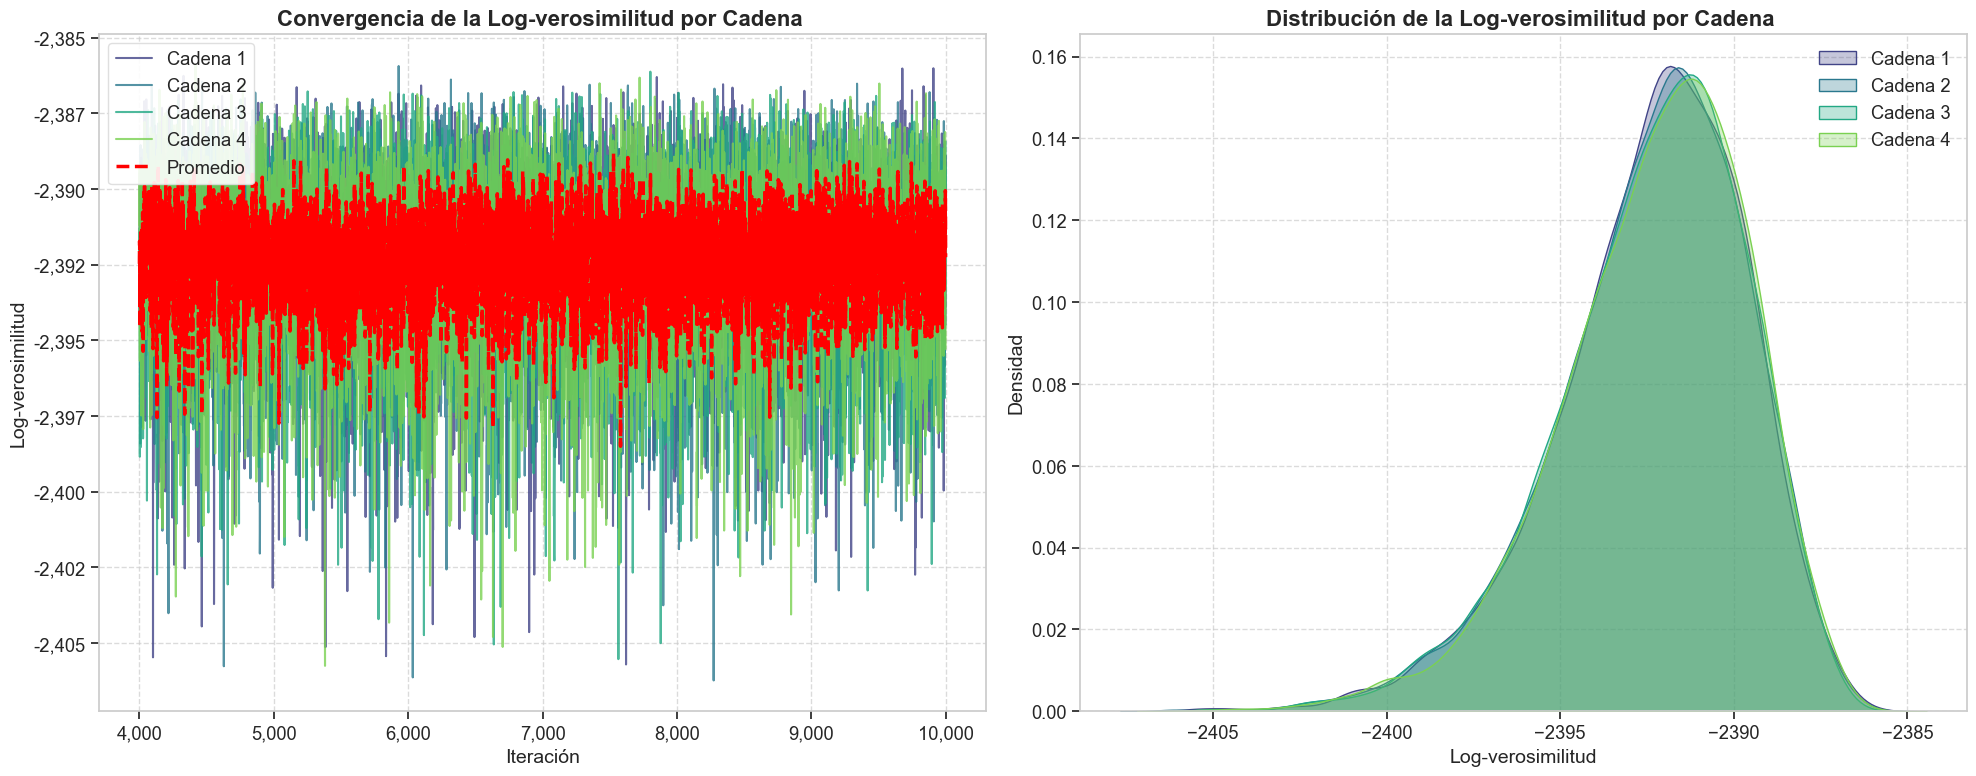

In [81]:
# Configuración estética general
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# Suponiendo que trace_hier ya contiene tus resultados del muestreo
# Extraer los valores del log-likelihood
log_likelihood = trace_hier.log_likelihood["Y_obs"]
log_posterior = log_likelihood.sum(dim="Y_obs_dim_0")
log_posterior_values = log_posterior.values

# Definir el punto de corte (iteración 2500)
start_iteration = 4000
log_posterior_values_filtered = log_posterior_values[:, start_iteration:]

# Figura combinada: Convergencia y distribución lado a lado
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Colores para cada cadena en un esquema agradable
colors = sns.color_palette("viridis", log_posterior_values_filtered.shape[0])

# GRÁFICO 1: Convergencia por cadena (izquierda)
for chain in range(log_posterior_values_filtered.shape[0]):
    axes[0].plot(
        np.arange(start_iteration, start_iteration + log_posterior_values_filtered.shape[1]), 
        log_posterior_values_filtered[chain], 
        label=f"Cadena {chain+1}",
        color=colors[chain],
        linewidth=1.5,
        alpha=0.8
    )

# Añadir línea de promedio
mean_posterior = np.mean(log_posterior_values_filtered, axis=0)
axes[0].plot(
    np.arange(start_iteration, start_iteration + mean_posterior.shape[0]), 
    mean_posterior, 
    label="Promedio",
    color="red",
    linewidth=2.5,
    linestyle="--"
)

# Mejorar ejes y leyendas
axes[0].set_xlabel("Iteración", fontsize=14)
axes[0].set_ylabel("Log-verosimilitud", fontsize=14)
axes[0].set_title(f"Convergencia de la Log-verosimilitud por Cadena ", 
                 fontsize=16, fontweight='bold')

# Formatear los ticks con mejor legibilidad
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Añadir un grid sutil
axes[0].grid(True, linestyle='--', alpha=0.7)

# Mejorar la leyenda
axes[0].legend(
    loc='upper left', 
    frameon=True, 
    fancybox=True, 
    framealpha=0.9,
    edgecolor='gainsboro'
)

# GRÁFICO 2: Distribución de densidad (derecha)
for chain in range(log_posterior_values_filtered.shape[0]):
    sns.kdeplot(
        log_posterior_values_filtered[chain],
        ax=axes[1],
        label=f"Cadena {chain+1}",
        color=colors[chain],
        fill=True,
        alpha=0.3
    )

axes[1].set_xlabel("Log-verosimilitud", fontsize=14)
axes[1].set_ylabel("Densidad", fontsize=14)
axes[1].set_title(f"Distribución de la Log-verosimilitud por Cadena ", 
                 fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ajustes finales
plt.tight_layout()
plt.savefig(f"Log_Posterior_MULTISIM2_desde.png", dpi=300, bbox_inches="tight")
plt.show()

##CONVERGENCIA DE THETA

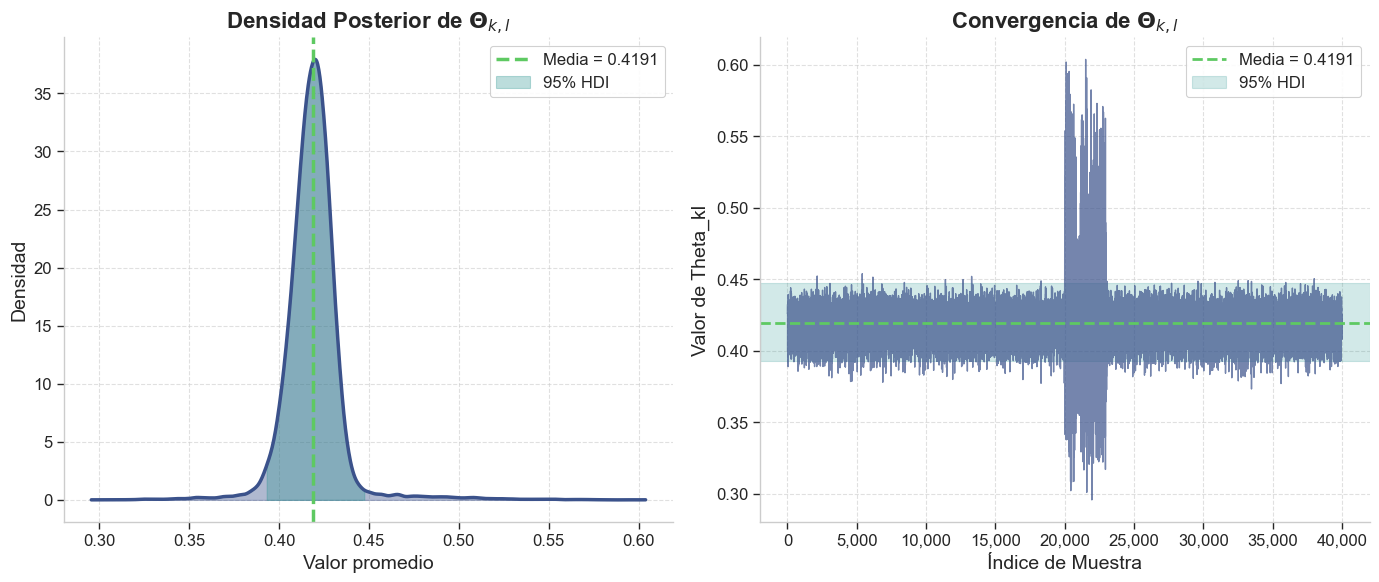

          Estadística     Valor
     Promedio de Mean     0.419
       Promedio de SD     0.016
   Promedio de HDI 3%     0.393
  Promedio de HDI 97%     0.440
Promedio de MCSE Mean     0.000
  Promedio de MCSE SD     0.001
 Promedio de ESS Bulk 19961.000
 Promedio de ESS Tail    30.000
    Promedio de R hat     1.060


In [8]:
import xarray as xr
# Configuración estética
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
colors = sns.color_palette("viridis", 3)

# Extraer los datos de Theta_kl del trace
theta_samples = trace_hier.posterior['Theta_kl'].values  # Cambio de trace a trace_hier
theta_samples_flattened = theta_samples.reshape(-1, theta_samples.shape[-1])
theta_means_per_sample = theta_samples_flattened.mean(axis=1)

# Calcular la media global
mean_value = theta_means_per_sample.mean()

# Calcular la densidad de kernel (KDE)
kde = gaussian_kde(theta_means_per_sample)
x_vals = np.linspace(theta_means_per_sample.min(), theta_means_per_sample.max(), 1000)
y_vals = kde(x_vals)

# Crear la figura con dos subgráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white')

# Gráfica de densidad (izquierda)
ax[0].plot(x_vals, y_vals, color=colors[0], linewidth=2.5)
ax[0].fill_between(x_vals, y_vals, color=colors[0], alpha=0.4)
ax[0].axvline(mean_value, color=colors[2], linestyle='--', linewidth=2.5, 
            label=f'Media = {mean_value:.4f}')

# Agregar sombreado para el intervalo HDI (95%)
lower_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 2.5))
upper_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 97.5))
ax[0].fill_between(x_vals[lower_idx:upper_idx], y_vals[lower_idx:upper_idx], 
                   color=colors[1], alpha=0.3,
                   label='95% HDI')

# Mejoras en la gráfica de densidad
ax[0].set_title(r'Densidad Posterior de $\mathbf{\Theta}_{k,l}$', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Valor promedio', fontsize=14)
ax[0].set_ylabel('Densidad', fontsize=14)
ax[0].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# Gráfica de traza (derecha)
ax[1].plot(theta_means_per_sample, color=colors[0], alpha=0.7, linewidth=1.0)
ax[1].axhline(y=mean_value, color=colors[2], linestyle='--', linewidth=2, 
             label=f'Media = {mean_value:.4f}')

# Sombreado para visualizar la variación
upper_bound = np.percentile(theta_means_per_sample, 97.5)
lower_bound = np.percentile(theta_means_per_sample, 2.5)
ax[1].axhspan(lower_bound, upper_bound, alpha=0.2, color=colors[1], label='95% HDI')

# Mejoras en la gráfica de traza
ax[1].set_title(r'Convergencia de $\mathbf{\Theta}_{k,l}$', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Índice de Muestra', fontsize=14)
ax[1].set_ylabel('Valor de Theta_kl', fontsize=14)
ax[1].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12, loc='upper right')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Formatear los valores de los ejes para mayor legibilidad
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Ajustes finales
plt.tight_layout()
plt.savefig("convThetaSIMUL2MULTI.png", dpi=300, bbox_inches="tight")
plt.show()

# El resto del código se mantiene igual (también cambiando trace por trace_hier)
theta_samples = trace_hier.posterior['Theta_kl'].values  # Cambio de trace a trace_hier
theta_means_per_chain = theta_samples.mean(axis=-1)  # (chains, draws)
# Convertir a xarray
theta_means_xr = xr.DataArray(
    theta_means_per_chain,
    dims=["chain", "draw"],
    name="theta_mean"
)
inference_data = az.from_dict(posterior={"theta_mean": theta_means_xr})
# Obtener resumen completo
summary_df = az.summary(inference_data, var_names=["theta_mean"], hdi_prob=0.94)
# Extraer estadísticas de interés
stats = {
    "Promedio de Mean": summary_df["mean"].values[0],
    "Promedio de SD": summary_df["sd"].values[0],
    "Promedio de HDI 3%": summary_df["hdi_3%"].values[0],
    "Promedio de HDI 97%": summary_df["hdi_97%"].values[0],
    "Promedio de MCSE Mean": summary_df["mcse_mean"].values[0],
    "Promedio de MCSE SD": summary_df["mcse_sd"].values[0],
    "Promedio de ESS Bulk": summary_df["ess_bulk"].values[0],
    "Promedio de ESS Tail": summary_df["ess_tail"].values[0],
    "Promedio de R hat": summary_df["r_hat"].values[0],
}
# Convertir a DataFrame para presentación bonita
tabla_estadisticas = pd.DataFrame({
    "Estadística": list(stats.keys()),
    "Valor": [round(v, 4) for v in stats.values()]
})
print(tabla_estadisticas.to_string(index=False))

Forma original de theta_samples: (4, 10000, 15)
ADVERTENCIA: No hay suficientes muestras. Total de muestras: 10000, índice de inicio solicitado: 25000
Ajustando índice de inicio a: 5000
Forma de theta_samples_filtered: (4, 5000, 15)
Forma de theta_means_per_sample: (20000,)
Número de elementos en theta_means_per_sample: 20000
Media calculada: 0.4181485358213858


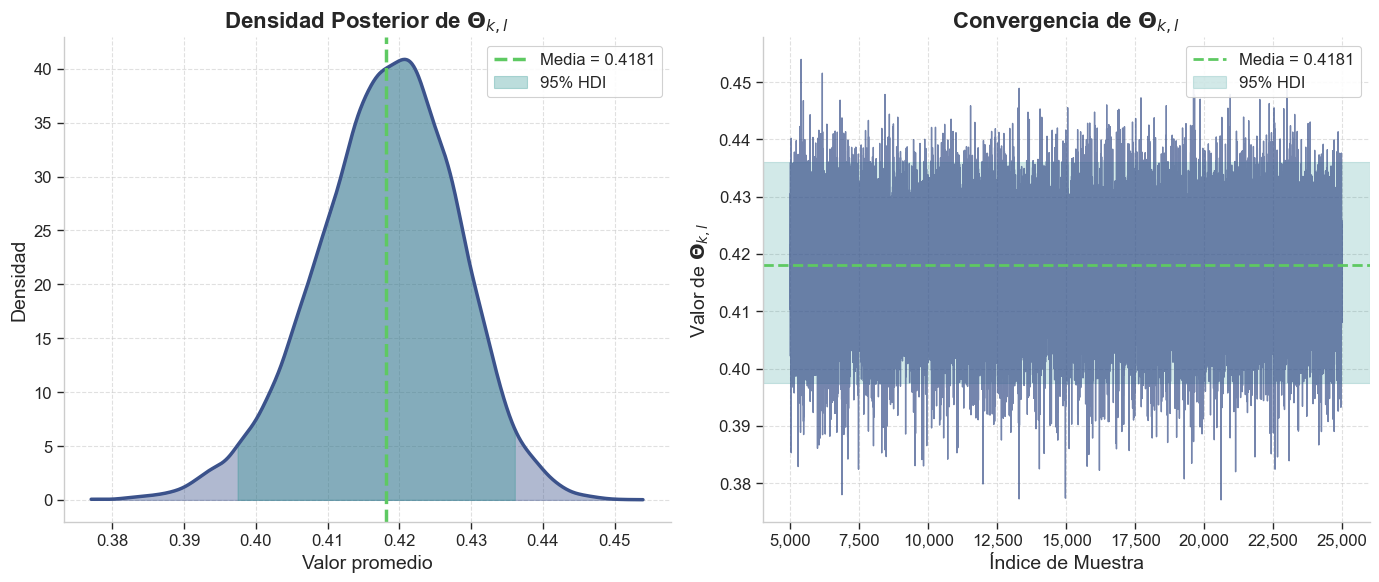


Estadísticas para Theta_kl (desde muestra 5000):
          Estadística     Valor
     Promedio de Mean     0.418
       Promedio de SD     0.010
   Promedio de HDI 3%     0.399
  Promedio de HDI 97%     0.436
Promedio de MCSE Mean     0.000
  Promedio de MCSE SD     0.000
 Promedio de ESS Bulk 22955.000
 Promedio de ESS Tail 15493.000
    Promedio de R hat     1.000


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import xarray as xr
import arviz as az
from scipy.stats import gaussian_kde

# Configuración estética
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
colors = sns.color_palette("viridis", 3)

# Extraer los datos de Theta_kl del trace
theta_samples = trace_hier.posterior['Theta_kl'].values

# Definir el punto de corte (índice 25000)
start_idx = 25000

# Comprobar la estructura de theta_samples para entender cómo filtrar correctamente
print(f"Forma original de theta_samples: {theta_samples.shape}")

# Verificar si tenemos suficientes muestras después del índice 25000
if len(theta_samples.shape) >= 2 and theta_samples.shape[1] <= start_idx:
    print(f"ADVERTENCIA: No hay suficientes muestras. Total de muestras: {theta_samples.shape[1]}, índice de inicio solicitado: {start_idx}")
    # Usar un valor más apropiado: la mitad de las muestras disponibles
    start_idx = theta_samples.shape[1] // 2
    print(f"Ajustando índice de inicio a: {start_idx}")

# Filtrar las muestras correctamente según la estructura
if len(theta_samples.shape) == 4:  # Si tiene forma (chains, draws, k, l)
    theta_samples_filtered = theta_samples[:, start_idx:, :, :]
    # Aplanar para el análisis
    theta_samples_flattened = theta_samples_filtered.reshape(-1, theta_samples_filtered.shape[2] * theta_samples_filtered.shape[3])
    theta_means_per_sample = theta_samples_flattened.mean(axis=1)
elif len(theta_samples.shape) == 3:  # Si tiene forma (chains, draws, params)
    theta_samples_filtered = theta_samples[:, start_idx:, :]
    # Aplanar para el análisis
    theta_samples_flattened = theta_samples_filtered.reshape(-1, theta_samples_filtered.shape[2])
    theta_means_per_sample = theta_samples_flattened.mean(axis=1)
else:  # Si tiene forma (chains, draws) o similar
    theta_samples_filtered = theta_samples[:, start_idx:]
    # Verificar si necesitamos aplanar o si ya está en el formato correcto
    if len(theta_samples_filtered.shape) > 2:
        theta_samples_flattened = theta_samples_filtered.reshape(-1, theta_samples_filtered.shape[-1])
    else:
        theta_samples_flattened = theta_samples_filtered.reshape(-1)
    
    if theta_samples_flattened.ndim > 1:
        theta_means_per_sample = theta_samples_flattened.mean(axis=1)
    else:
        theta_means_per_sample = theta_samples_flattened

print(f"Forma de theta_samples_filtered: {theta_samples_filtered.shape}")
print(f"Forma de theta_means_per_sample: {theta_means_per_sample.shape}")
print(f"Número de elementos en theta_means_per_sample: {len(theta_means_per_sample)}")

# Verificar que tengamos datos válidos
if len(theta_means_per_sample) == 0:
    raise ValueError("No hay datos después de filtrar. Verifica el índice de inicio y la estructura de los datos.")

# Calcular la media global
mean_value = theta_means_per_sample.mean()
print(f"Media calculada: {mean_value}")

# Calcular la densidad de kernel (KDE)
kde = gaussian_kde(theta_means_per_sample)
x_vals = np.linspace(np.min(theta_means_per_sample), np.max(theta_means_per_sample), 1000)
y_vals = kde(x_vals)

# Crear la figura con dos subgráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white')

# Gráfica de densidad (izquierda)
ax[0].plot(x_vals, y_vals, color=colors[0], linewidth=2.5)
ax[0].fill_between(x_vals, y_vals, color=colors[0], alpha=0.4)
ax[0].axvline(mean_value, color=colors[2], linestyle='--', linewidth=2.5, 
            label=f'Media = {mean_value:.4f}')

# Agregar sombreado para el intervalo HDI (95%)
lower_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 2.5))
upper_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 97.5))
ax[0].fill_between(x_vals[lower_idx:upper_idx], y_vals[lower_idx:upper_idx], 
                   color=colors[1], alpha=0.3,
                   label='95% HDI')

# Mejoras en la gráfica de densidad
ax[0].set_title(r'Densidad Posterior de $\mathbf{\Theta}_{k,l}$ ', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Valor promedio', fontsize=14)
ax[0].set_ylabel('Densidad', fontsize=14)
ax[0].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# Gráfica de traza (derecha)
# Crear un eje x que comience desde el índice start_idx
x_indices = np.arange(start_idx, start_idx + len(theta_means_per_sample))

ax[1].plot(x_indices, theta_means_per_sample, color=colors[0], alpha=0.7, linewidth=1.0)
ax[1].axhline(y=mean_value, color=colors[2], linestyle='--', linewidth=2, 
             label=f'Media = {mean_value:.4f}')

# Sombreado para visualizar la variación
upper_bound = np.percentile(theta_means_per_sample, 97.5)
lower_bound = np.percentile(theta_means_per_sample, 2.5)
ax[1].axhspan(lower_bound, upper_bound, alpha=0.2, color=colors[1], label='95% HDI')

# Mejoras en la gráfica de traza
ax[1].set_title(r'Convergencia de $\mathbf{\Theta}_{k,l}$ ', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Índice de Muestra', fontsize=14)
ax[1].set_ylabel('Valor de $\mathbf{\Theta}_{k,l}$', fontsize=14)
ax[1].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12, loc='upper right')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Formatear los valores de los ejes para mayor legibilidad
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Ajustes finales
plt.tight_layout()
plt.savefig(f"convThetaSIMUL2MULTIdesde.png", dpi=300, bbox_inches="tight")
plt.show()

# Análisis estadístico con arviz, solo usando las muestras después del índice start_idx
# Extraer las medias por cadena
if len(theta_samples_filtered.shape) >= 3:
    theta_means_per_chain = theta_samples_filtered.mean(axis=tuple(range(2, len(theta_samples_filtered.shape))))
else:
    theta_means_per_chain = theta_samples_filtered

# Convertir a xarray
theta_means_xr = xr.DataArray(
    theta_means_per_chain,
    dims=["chain", "draw"],
    name="theta_mean"
)
inference_data = az.from_dict(posterior={"theta_mean": theta_means_xr})

# Obtener resumen completo
summary_df = az.summary(inference_data, var_names=["theta_mean"], hdi_prob=0.94)

# Extraer estadísticas de interés
stats = {
    "Promedio de Mean": summary_df["mean"].values[0],
    "Promedio de SD": summary_df["sd"].values[0],
    "Promedio de HDI 3%": summary_df["hdi_3%"].values[0],
    "Promedio de HDI 97%": summary_df["hdi_97%"].values[0],
    "Promedio de MCSE Mean": summary_df["mcse_mean"].values[0],
    "Promedio de MCSE SD": summary_df["mcse_sd"].values[0],
    "Promedio de ESS Bulk": summary_df["ess_bulk"].values[0],
    "Promedio de ESS Tail": summary_df["ess_tail"].values[0],
    "Promedio de R hat": summary_df["r_hat"].values[0],
}

# Convertir a DataFrame para presentación bonita
tabla_estadisticas = pd.DataFrame({
    "Estadística": list(stats.keys()),
    "Valor": [round(v, 4) for v in stats.values()]
})

print("\nEstadísticas para Theta_kl (desde muestra " + str(start_idx) + "):")
print(tabla_estadisticas.to_string(index=False))

##MATRIZ DE INCICENDIA

Adjusted Rand Index: 0.4348
Normalized Mutual Information: 0.6857

Bloque Assignments Summary:
Block 1: 15 nodes - [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Block 2: 44 nodes - [2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Block 3: 5 nodes - [41, 42, 43, 44, 45]
Block 4: 36 nodes - [1, 4, 5, 6, 7, 8, 9, 18, 19, 24, 25, 26, 27, 28, 36, 39, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


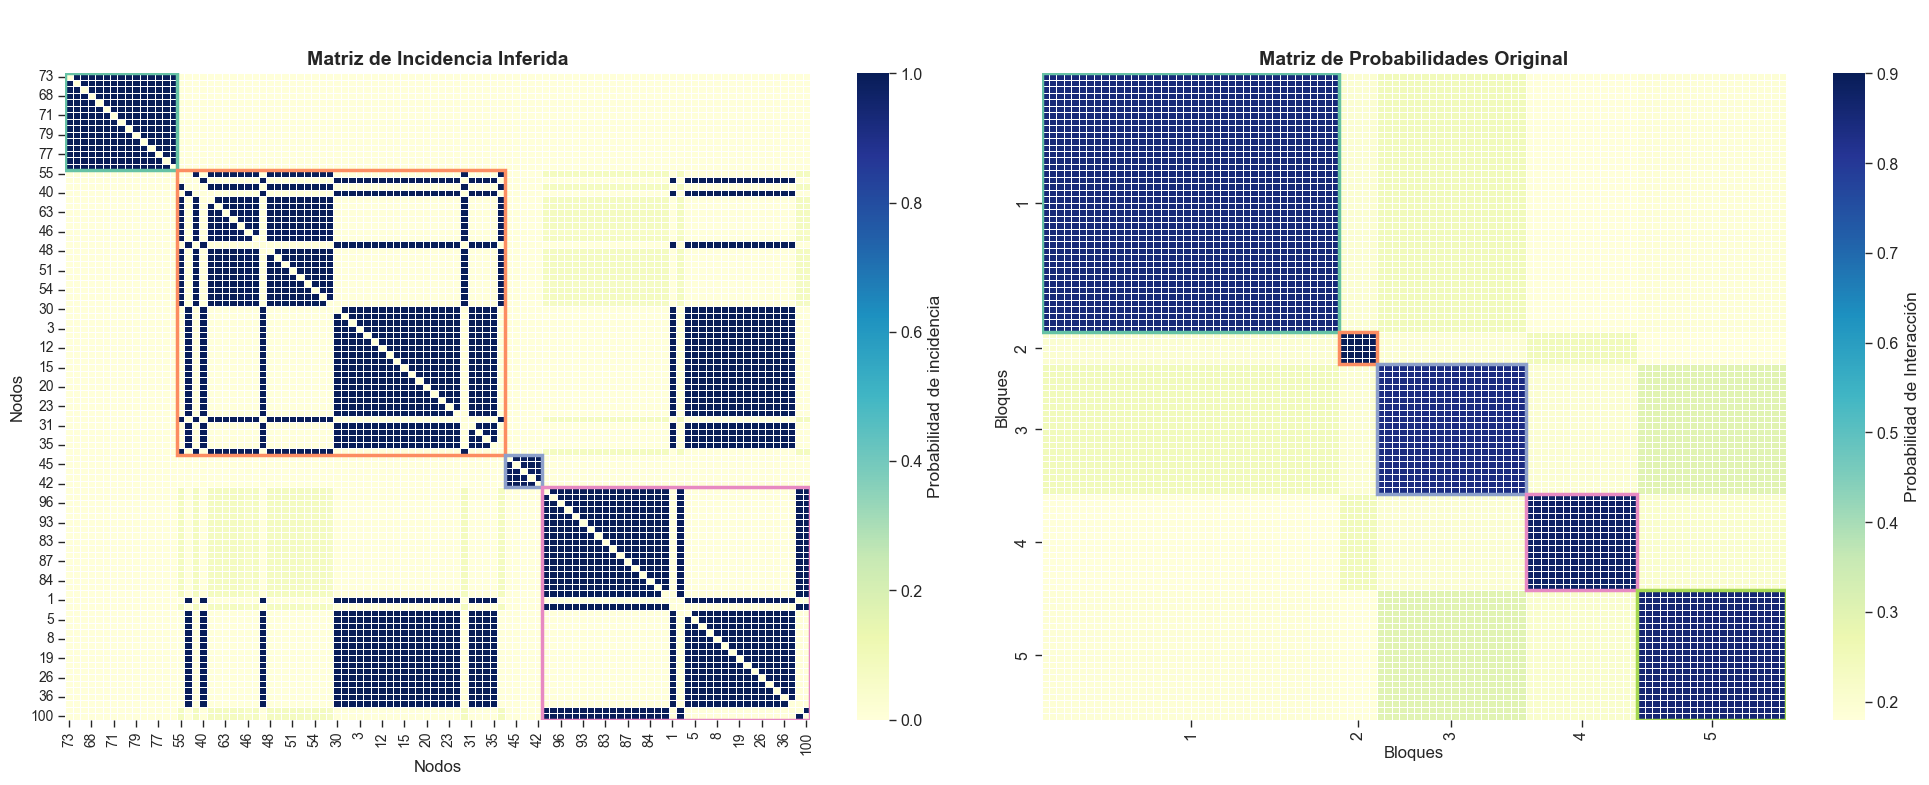

In [10]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
# Original probability matrix for comparison
original_prob_matrix = np.array([
    [0.85, 0.20, 0.25, 0.18, 0.19],
    [0.20, 0.90, 0.20, 0.25, 0.18],
    [0.25, 0.20, 0.84, 0.20, 0.30],
    [0.18, 0.25, 0.20, 0.88, 0.21],
    [0.19, 0.18, 0.30, 0.21, 0.86]
])

# Original true block assignments 
n_nodos = 100
proporciones = np.array([0.4, 0.05, 0.2, 0.15, 0.2])
nodos_por_bloque = np.round(proporciones * n_nodos).astype(int)
if np.sum(nodos_por_bloque) != n_nodos:
    diferencia = n_nodos - np.sum(nodos_por_bloque)
    nodos_por_bloque[-1] += diferencia

# Create the true block assignment vector
true_assignments = np.zeros(n_nodos, dtype=int)
start_idx = 0
for block_idx, count in enumerate(nodos_por_bloque):
    true_assignments[start_idx:start_idx+count] = block_idx
    start_idx += count

# Your existing code
E_samples = trace_hier.posterior["E_vector"].values  
E_samples = E_samples.reshape(-1, 100)  # (total_samples, 100)
num_samples = E_samples.shape[0]
coincidence_matrices = np.zeros((num_samples, 100, 100), dtype=int)
for i in range(num_samples):
    sample = E_samples[i] 
    coincidence_matrices[i] = (sample[:, None] == sample[None, :]).astype(int)  
E_samples = E_samples.reshape(-1, E_samples.shape[-1])
num_samples, num_nodes = E_samples.shape
incidence_matrix_avg = np.zeros((num_nodes, num_nodes))
for sample in E_samples:
    order = np.argsort(sample)
    incidence_matrix = np.zeros((num_nodes, num_nodes))
    unique_labels = np.unique(sample)
    for label in unique_labels:
        members = np.where(sample == label)[0]  
        incidence_matrix[np.ix_(members, members)] = 1
    incidence_matrix = incidence_matrix[np.ix_(order, order)]
    incidence_matrix_avg += incidence_matrix
incidence_matrix_avg /= num_samples
incidence_matrix_rounded = np.round(incidence_matrix_avg, 2)

# Define a robust mode function
def robust_mode(arr):
    unique, counts = np.unique(arr, return_counts=True)
    max_count = np.max(counts)
    candidates = unique[counts == max_count]  
    return np.min(candidates)  

# Get mode assignments for each node
num_blocks = np.max(E_samples) + 1  
E_modes = np.array([robust_mode(E_samples[:, i]) for i in range(num_nodes)])

# Create a more consistent block mapping
unique_blocks = np.unique(E_modes)
block_mapping = {block: i for i, block in enumerate(unique_blocks)}
E_modes_mapped = np.array([block_mapping[b] for b in E_modes])

# Create incidence matrix
incidence_matrix = np.zeros((num_nodes, num_nodes))
for sample in E_samples:
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if sample[i] == sample[j]:  
                incidence_matrix[i, j] += 1
                incidence_matrix[j, i] += 1  

incidence_matrix /= E_samples.shape[0]
incidence_matrix_rounded = np.round(incidence_matrix, 2)

# Sort by the mapped block assignments
sorted_indices = np.argsort(E_modes_mapped)
incidence_matrix_sorted = incidence_matrix_rounded[np.ix_(sorted_indices, sorted_indices)]
df_sorted = pd.DataFrame(incidence_matrix_sorted, index=sorted_indices+1, columns=sorted_indices+1)

# Calculate similarity metrics between inferred and true assignments
rand_score = adjusted_rand_score(true_assignments, E_modes_mapped)
nmi_score = normalized_mutual_info_score(true_assignments, E_modes_mapped)

print(f"Adjusted Rand Index: {rand_score:.4f}")
print(f"Normalized Mutual Information: {nmi_score:.4f}")

# Create a summary of node assignments to blocks
block_summary = {}
for block in range(len(unique_blocks)):
    nodes_in_block = np.where(E_modes_mapped == block)[0] + 1  # +1 for 1-indexing
    block_summary[f"Block {block+1}"] = {
        "Nodes": nodes_in_block.tolist(),
        "Count": len(nodes_in_block)
    }

# Print block summary
print("\nBloque Assignments Summary:")
for block, info in block_summary.items():
    print(f"{block}: {info['Count']} nodes - {info['Nodes']}")

def expand_probability_matrix(prob_matrix, block_sizes):
    """
    Expande una matriz de probabilidades entre bloques para mostrar el tamaño real de cada bloque.
    """
    K = len(block_sizes)
    total_nodes = sum(block_sizes)
    expanded_matrix = np.zeros((total_nodes, total_nodes))
    
    # Índices de inicio para cada bloque
    start_indices = np.zeros(K, dtype=int)
    for i in range(1, K):
        start_indices[i] = start_indices[i-1] + block_sizes[i-1]
    
    # Expandir la matriz
    for i in range(K):
        for j in range(K):
            # Obtener los índices de inicio y fin para los bloques i y j
            i_start, i_end = start_indices[i], start_indices[i] + block_sizes[i]
            j_start, j_end = start_indices[j], start_indices[j] + block_sizes[j]
            
            # Asignar la probabilidad correspondiente a todos los nodos de estos bloques
            expanded_matrix[i_start:i_end, j_start:j_end] = prob_matrix[i, j]
    
    return expanded_matrix, start_indices

# Expandir la matriz de probabilidades original
expanded_prob_matrix, start_indices = expand_probability_matrix(original_prob_matrix, nodos_por_bloque)

# Visualizar ambas matrices lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define una paleta de colores más elegante
elegant_cmap = sns.color_palette("YlGnBu", as_cmap=True)

# Plot inferred incidence matrix (mantener como estaba)
sns.heatmap(df_sorted, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white', ax=axes[0],
            cbar_kws={'label': 'Probabilidad de incidencia'})
axes[0].set_title("Matriz de Incidencia Inferida", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Nodos", fontsize=12)
axes[0].set_ylabel("Nodos", fontsize=12)
axes[0].tick_params(labelsize=10)

# Plot expanded original probability matrix (con etiquetas de bloques)
sns.heatmap(expanded_prob_matrix, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white', ax=axes[1],
            cbar_kws={'label': 'Probabilidad de Interacción'})
axes[1].set_title("Matriz de Probabilidades Original", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Bloques", fontsize=12)
axes[1].set_ylabel("Bloques", fontsize=12)

# Configurar etiquetas de bloques para la matriz original expandida
orig_block_positions = []
for i in range(len(nodos_por_bloque)):
    block_mid = start_indices[i] + nodos_por_bloque[i] / 2
    orig_block_positions.append((block_mid, f"{i+1}"))  # Solo números 1, 2, 3, 4, 5

axes[1].set_xticks([pos[0] for pos in orig_block_positions])
axes[1].set_xticklabels([pos[1] for pos in orig_block_positions])
axes[1].set_yticks([pos[0] for pos in orig_block_positions])
axes[1].set_yticklabels([pos[1] for pos in orig_block_positions])

# Add block boundaries to both matrices
# Para la matriz inferida
current_pos = 0
num_blocks_inferred = len(unique_blocks)
elegant_boundary_palette = sns.color_palette("Set2", max(num_blocks_inferred, len(nodos_por_bloque)))

for block_idx in range(num_blocks_inferred):
    block_size = np.sum(E_modes_mapped[sorted_indices] == block_idx)
    if block_size > 0:
        axes[0].add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

# Para la matriz de probabilidades original expandida
current_pos = 0
for block_idx, block_size in enumerate(nodos_por_bloque):
    if block_size > 0:
        axes[1].add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

# Mejorar la apariencia general
fig.suptitle(" ", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig("INCIDENCIAJERAR_sim2.png", dpi=300, bbox_inches='tight')
plt.show()

Forma original de E_samples: (4, 10000, 100)
Forma final de E_samples para análisis: (20000, 100)
Usando muestras desde la iteración: 5000
Adjusted Rand Index (muestras convergentes): 0.6493
Normalized Mutual Information (muestras convergentes): 0.8477

Bloque Assignments Summary (muestras convergentes):
Block 1: 15 nodes - [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Block 2: 60 nodes - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Block 3: 5 nodes - [41, 42, 43, 44, 45]
Block 4: 20 nodes - [81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


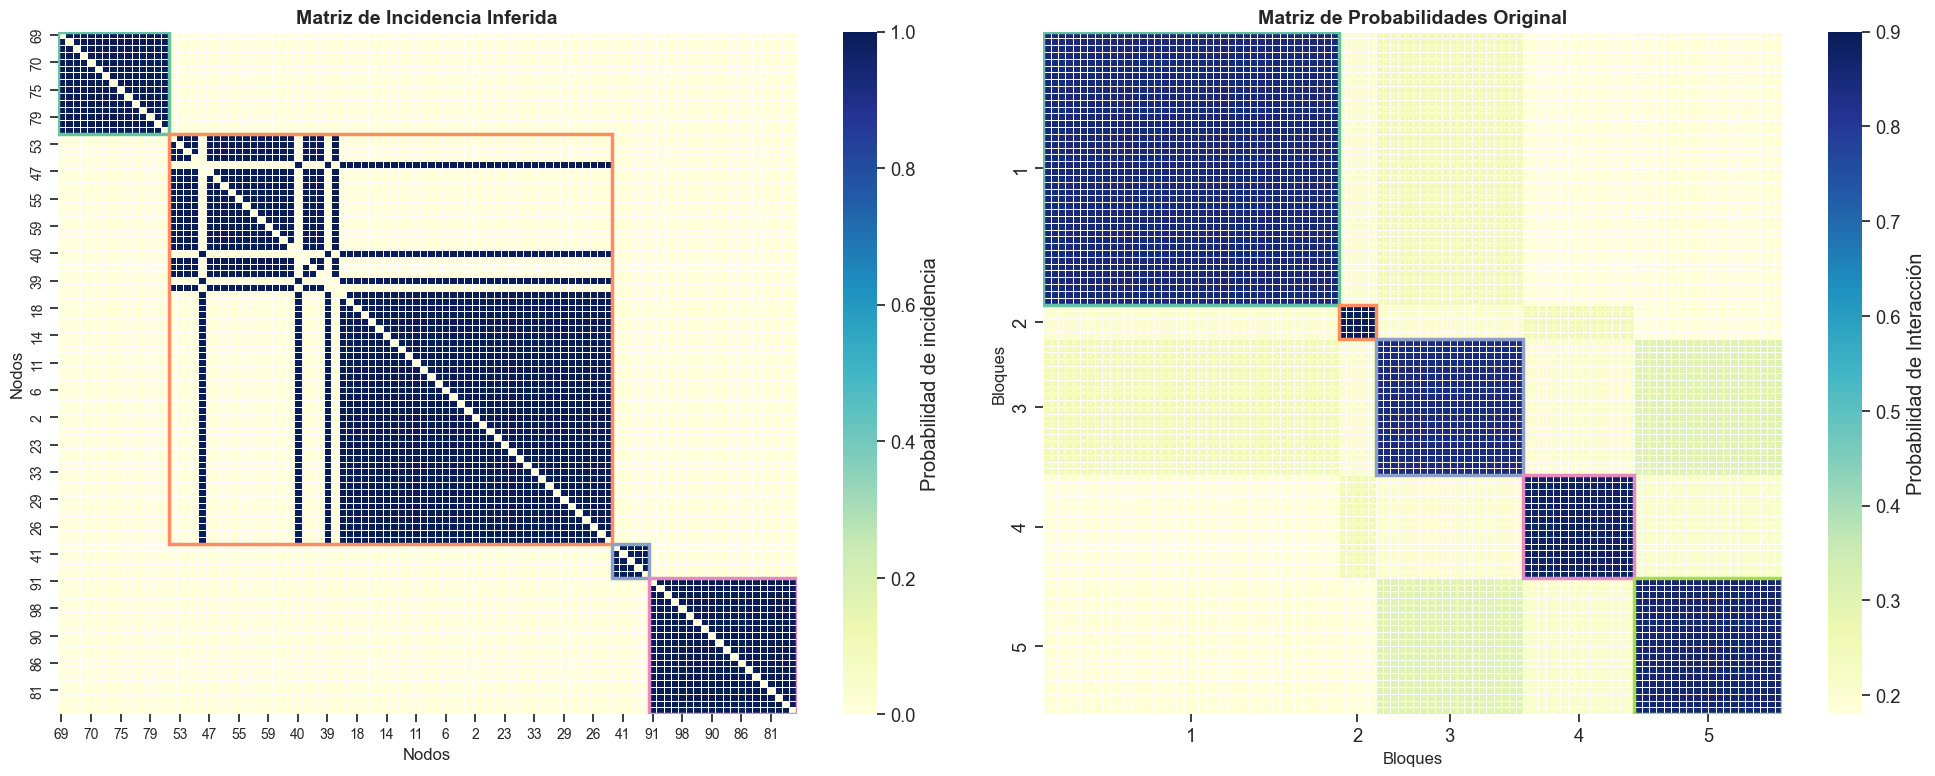

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ---- PARÁMETROS ----
# Punto de inicio para usar solo muestras convergentes (la mitad de las muestras)
start_idx = 5000  # Mitad de 10000 iteraciones

# Original probability matrix for comparison
original_prob_matrix = np.array([
    [0.85, 0.20, 0.25, 0.18, 0.19],
    [0.20, 0.90, 0.20, 0.25, 0.18],
    [0.25, 0.20, 0.84, 0.20, 0.30],
    [0.18, 0.25, 0.20, 0.88, 0.21],
    [0.19, 0.18, 0.30, 0.21, 0.86]
])

# Original true block assignments 
n_nodos = 100
proporciones = np.array([0.4, 0.05, 0.2, 0.15, 0.2])
nodos_por_bloque = np.round(proporciones * n_nodos).astype(int)
if np.sum(nodos_por_bloque) != n_nodos:
    diferencia = n_nodos - np.sum(nodos_por_bloque)
    nodos_por_bloque[-1] += diferencia

# Create the true block assignment vector
true_assignments = np.zeros(n_nodos, dtype=int)
start_node_idx = 0
for block_idx, count in enumerate(nodos_por_bloque):
    true_assignments[start_node_idx:start_node_idx+count] = block_idx
    start_node_idx += count

# ---- EXTRACCIÓN Y FILTRADO DE MUESTRAS CONVERGENTES ----
# Extraer las muestras de E_vector del trace
E_samples_full = trace_hier.posterior["E_vector"].values

# Imprimir forma para diagnóstico
print(f"Forma original de E_samples: {E_samples_full.shape}")

# Filtrar para usar solo las muestras después de start_idx
# Asumiendo que E_samples_full tiene forma (chains, draws, nodes)
if len(E_samples_full.shape) == 3:
    E_samples_filtered = E_samples_full[:, start_idx:, :]
    # Reshape para tener todas las muestras juntas
    num_chains = E_samples_filtered.shape[0]
    num_draws_per_chain = E_samples_filtered.shape[1]
    num_nodes = E_samples_filtered.shape[2]
    E_samples = E_samples_filtered.reshape(num_chains * num_draws_per_chain, num_nodes)
else:
    # Si la forma es diferente, adaptar según sea necesario
    E_samples = E_samples_full.reshape(-1, E_samples_full.shape[-1])
    total_samples = E_samples.shape[0]
    samples_to_keep = total_samples // 2  # Mitad de las muestras si no podemos identificar la estructura
    E_samples = E_samples[total_samples - samples_to_keep:, :]

print(f"Forma final de E_samples para análisis: {E_samples.shape}")
print(f"Usando muestras desde la iteración: {start_idx}")

# ---- FUNCIONES AUXILIARES ----
def robust_mode(arr):
    """Encuentra el modo robusto de un array."""
    unique, counts = np.unique(arr, return_counts=True)
    max_count = np.max(counts)
    candidates = unique[counts == max_count]  
    return np.min(candidates)  

def expand_probability_matrix(prob_matrix, block_sizes):
    """
    Expande una matriz de probabilidades entre bloques para mostrar el tamaño real de cada bloque.
    """
    K = len(block_sizes)
    total_nodes = sum(block_sizes)
    expanded_matrix = np.zeros((total_nodes, total_nodes))
    
    # Índices de inicio para cada bloque
    start_indices = np.zeros(K, dtype=int)
    for i in range(1, K):
        start_indices[i] = start_indices[i-1] + block_sizes[i-1]
    
    # Expandir la matriz
    for i in range(K):
        for j in range(K):
            # Obtener los índices de inicio y fin para los bloques i y j
            i_start, i_end = start_indices[i], start_indices[i] + block_sizes[i]
            j_start, j_end = start_indices[j], start_indices[j] + block_sizes[j]
            
            # Asignar la probabilidad correspondiente a todos los nodos de estos bloques
            expanded_matrix[i_start:i_end, j_start:j_end] = prob_matrix[i, j]
    
    return expanded_matrix, start_indices

# ---- CÁLCULO DE LA MATRIZ DE INCIDENCIA A PARTIR DE LAS MUESTRAS CONVERGENTES ----
# Get total number of samples and nodes
num_samples, num_nodes = E_samples.shape

# Create incidence matrix
incidence_matrix = np.zeros((num_nodes, num_nodes))
for sample in E_samples:
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if sample[i] == sample[j]:  
                incidence_matrix[i, j] += 1
                incidence_matrix[j, i] += 1  

incidence_matrix /= num_samples
incidence_matrix_rounded = np.round(incidence_matrix, 2)

# Get mode assignments for each node
E_modes = np.array([robust_mode(E_samples[:, i]) for i in range(num_nodes)])

# Create a more consistent block mapping
unique_blocks = np.unique(E_modes)
block_mapping = {block: i for i, block in enumerate(unique_blocks)}
E_modes_mapped = np.array([block_mapping[b] for b in E_modes])

# Sort by the mapped block assignments
sorted_indices = np.argsort(E_modes_mapped)
incidence_matrix_sorted = incidence_matrix_rounded[np.ix_(sorted_indices, sorted_indices)]
df_sorted = pd.DataFrame(incidence_matrix_sorted, index=sorted_indices+1, columns=sorted_indices+1)

# ---- MÉTRICAS DE EVALUACIÓN ----
# Calculate similarity metrics with true assignments
rand_score = adjusted_rand_score(true_assignments, E_modes_mapped)
nmi_score = normalized_mutual_info_score(true_assignments, E_modes_mapped)

print(f"Adjusted Rand Index (muestras convergentes): {rand_score:.4f}")
print(f"Normalized Mutual Information (muestras convergentes): {nmi_score:.4f}")

# Create a summary of node assignments to blocks
block_summary = {}
for block in range(len(unique_blocks)):
    nodes_in_block = np.where(E_modes_mapped == block)[0] + 1  # +1 for 1-indexing
    block_summary[f"Block {block+1}"] = {
        "Nodes": nodes_in_block.tolist(),
        "Count": len(nodes_in_block)
    }

# Print block summary
print("\nBloque Assignments Summary (muestras convergentes):")
for block, info in block_summary.items():
    print(f"{block}: {info['Count']} nodes - {info['Nodes']}")

# ---- VISUALIZACIÓN ----
# Expandir la matriz de probabilidades original
expanded_prob_matrix, start_indices = expand_probability_matrix(original_prob_matrix, nodos_por_bloque)

# Visualizar ambas matrices lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define una paleta de colores más elegante
elegant_cmap = sns.color_palette("YlGnBu", as_cmap=True)

# Plot inferred incidence matrix (mantener como estaba)
sns.heatmap(df_sorted, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white', ax=axes[0],
            cbar_kws={'label': 'Probabilidad de incidencia'})
axes[0].set_title(f"Matriz de Incidencia Inferida", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Nodos", fontsize=12)
axes[0].set_ylabel("Nodos", fontsize=12)
axes[0].tick_params(labelsize=10)

# Plot expanded original probability matrix (con etiquetas de bloques)
sns.heatmap(expanded_prob_matrix, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white', ax=axes[1],
            cbar_kws={'label': 'Probabilidad de Interacción'})
axes[1].set_title("Matriz de Probabilidades Original", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Bloques", fontsize=12)
axes[1].set_ylabel("Bloques", fontsize=12)

# Configurar etiquetas de bloques para la matriz original expandida
orig_block_positions = []
for i in range(len(nodos_por_bloque)):
    block_mid = start_indices[i] + nodos_por_bloque[i] / 2
    orig_block_positions.append((block_mid, f"{i+1}"))  # Solo números 1, 2, 3, 4, 5

axes[1].set_xticks([pos[0] for pos in orig_block_positions])
axes[1].set_xticklabels([pos[1] for pos in orig_block_positions])
axes[1].set_yticks([pos[0] for pos in orig_block_positions])
axes[1].set_yticklabels([pos[1] for pos in orig_block_positions])

# Add block boundaries to both matrices
# Para la matriz inferida
current_pos = 0
num_blocks_inferred = len(unique_blocks)
elegant_boundary_palette = sns.color_palette("Set2", max(num_blocks_inferred, len(nodos_por_bloque)))

for block_idx in range(num_blocks_inferred):
    block_size = np.sum(E_modes_mapped[sorted_indices] == block_idx)
    if block_size > 0:
        axes[0].add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

# Para la matriz de probabilidades original expandida
current_pos = 0
for block_idx, block_size in enumerate(nodos_por_bloque):
    if block_size > 0:
        axes[1].add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

# Mejorar la apariencia general
plt.tight_layout()
plt.savefig(f"InciMul_sim2.png", dpi=300, bbox_inches='tight')
plt.show()

##ESTADISTICAS DESCRIPTIVAS

Generando redes...
Calculando estadísticas de red...
Generando visualizaciones...


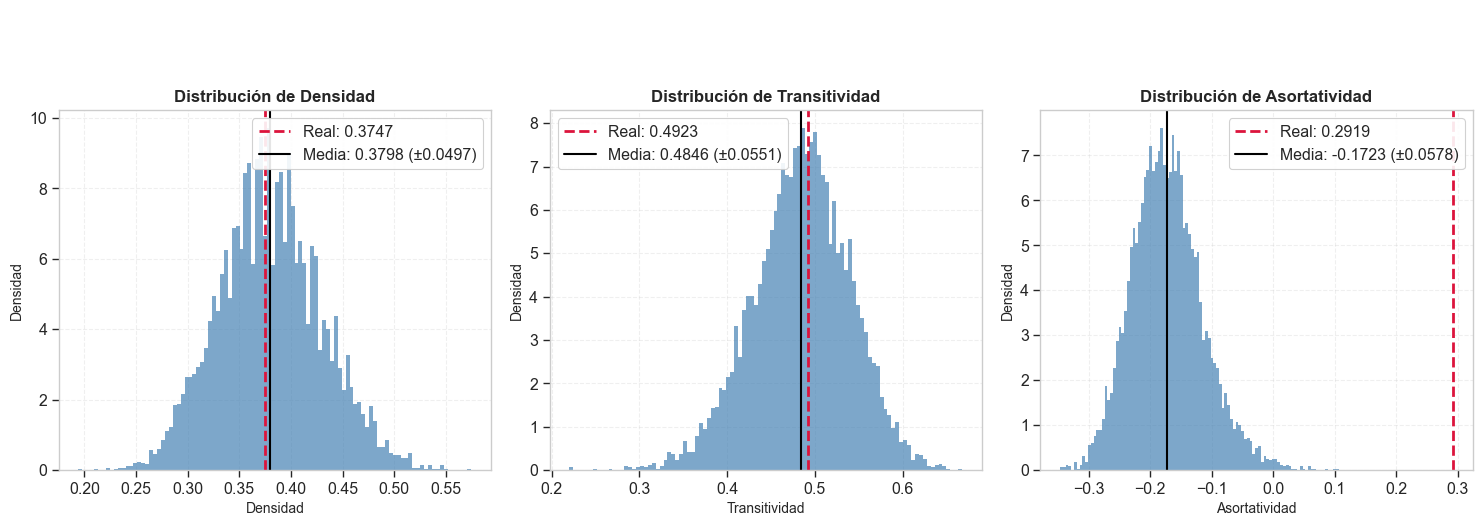


===== RESUMEN DE ESTADÍSTICAS =====

DENSIDAD:
  Real:              0.3747
  Media Simulada:    0.3798
  Desviación Std:    0.0497
  Error Absoluto:    0.0051
  Error Relativo:    1.36%

TRANSITIVIDAD:
  Real:              0.4923
  Media Simulada:    0.4846
  Desviación Std:    0.0551
  Error Absoluto:    0.0077
  Error Relativo:    1.57%

ASORTATIVIDAD:
  Real:              0.2919
  Media Simulada:    -0.1723
  Desviación Std:    0.0578
  Error Absoluto:    0.4642
  Error Relativo:    159.04%


In [75]:
from typing import Dict, List, Tuple, Any, Optional
import networkx as nx

def reconstruct_interaction_matrix(theta_samples: np.ndarray) -> np.ndarray:
    """
    Reconstruye la matriz completa de probabilidades de interacción a partir de muestras.
    
    Args:
        theta_samples: Array de muestras con forma 3D o 4D
        
    Returns:
        Array 3D de matrices de interacción reconstruidas
    """
    # Si es un array 4D (chains, draws, 8, 8), aplanar cadenas y muestras
    if theta_samples.ndim == 4:
        theta_samples = theta_samples.reshape(-1, theta_samples.shape[2], theta_samples.shape[3])
    
    # No es necesario iterar explícitamente, ya que theta_samples ya tiene la forma correcta
    return theta_samples


def safe_assortativity(G: nx.Graph) -> float:
    """
    Cálculo seguro de asortatividad con múltiples métodos de respaldo.
    
    Args:
        G: Grafo de NetworkX
        
    Returns:
        Coeficiente de asortatividad o 0 si no se puede calcular
    """
    try:
        # Primero intentar asortatividad por grado
        assort = nx.degree_assortativity_coefficient(G)
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    try:
        # Intentar asortatividad por atributo aleatorio
        nx.set_node_attributes(G, {n: np.random.random() for n in G.nodes()}, 'random_attr')
        assort = nx.attribute_assortativity_coefficient(G, 'random_attr')
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    return 0  # Valor por defecto si todos los métodos fallan


def generate_networks(
    interaction_matrices: np.ndarray, 
    num_nodes: int, 
    num_blocks: int, 
    networks_per_matrix: int = 2000
) -> List[nx.Graph]:
    """
    Genera múltiples redes basadas en los parámetros muestreados.
    
    Args:
        interaction_matrices: Array de matrices de interacción
        num_nodes: Número de nodos en cada red
        num_blocks: Número de bloques en el modelo
        networks_per_matrix: Número de redes a generar por matriz
        
    Returns:
        Lista de grafos generados
    """
    networks = []
    
    for matrix in interaction_matrices:
        # Generar múltiples redes para cada matriz de interacción
        for _ in range(networks_per_matrix):
            # Simulación de asignación de bloques uniforme
            block_assignments = np.random.randint(0, num_blocks, size=num_nodes)
            
            # Inicializar grafo
            G = nx.Graph()
            G.add_nodes_from(range(num_nodes))
            
            # Generar matriz de adyacencia eficientemente
            edges = []
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    block_i, block_j = block_assignments[i], block_assignments[j]
                    if np.random.random() < matrix[block_i, block_j]:
                        edges.append((i, j))
            
            G.add_edges_from(edges)
            networks.append(G)
    
    return networks


def compute_network_statistics(networks: List[nx.Graph]) -> Dict[str, List[float]]:
    """
    Calcula estadísticas de red: densidad, transitividad, asortatividad.
    
    Args:
        networks: Lista de grafos de NetworkX
        
    Returns:
        Diccionario con estadísticas calculadas
    """
    stats = {
        'densidad': [],
        'transitividad': [],
        'asortatividad': []
    }
    
    for G in networks:
        # Densidad
        stats['densidad'].append(nx.density(G))
        
        # Transitividad con manejo de excepciones
        try:
            transitivity = nx.transitivity(G)
            stats['transitividad'].append(transitivity if not np.isnan(transitivity) else 0)
        except (nx.NetworkXError, ZeroDivisionError):
            stats['transitividad'].append(0)
        
        # Asortatividad
        stats['asortatividad'].append(safe_assortativity(G))
    
    return stats


def plot_statistics_comparison(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float], 
    output_file: Optional[str] = "precision_estMSBSIM1.png"
) -> plt.Figure:
    """
    Compara las estadísticas de red generadas con los valores reales.
    
    Args:
        stats: Diccionario con estadísticas calculadas
        real_stats: Diccionario con valores reales de referencia
        output_file: Nombre del archivo para guardar la figura
        
    Returns:
        Figura de matplotlib
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    stat_names = ['densidad', 'transitividad', 'asortatividad']
    
    for i, stat_name in enumerate(stat_names):
        # Filtrar valores NaN
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        # Calcular estadísticas
        posterior_mean = np.mean(valid_stats)
        posterior_std = np.std(valid_stats)
        
        # Histograma con densidad de probabilidad
        axes[i].hist(valid_stats, bins=min(100, len(valid_stats)//50 + 10), 
                    density=True, alpha=0.7, color='steelblue')
        
        # Valor real
        axes[i].axvline(real_stats[stat_name], color='crimson', linestyle='--', linewidth=2,
                       label=f'Real: {real_stats[stat_name]:.4f}')
        
        # Media posterior
        axes[i].axvline(posterior_mean, color='black', linestyle='-', linewidth=1.5,
                       label=f'Media: {posterior_mean:.4f} (±{posterior_std:.4f})')
        
        # Mejorar apariencia
        axes[i].set_title(f'Distribución de {stat_name.capitalize()}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(stat_name.capitalize(), fontsize=10)
        axes[i].set_ylabel('Densidad', fontsize=10)
        axes[i].grid(alpha=0.3, linestyle='--')
        axes[i].legend(loc='best', frameon=True, framealpha=0.9)
    
    plt.suptitle(' ', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    # Guardar figura si se especificó un nombre de archivo
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig


def summarize_statistics(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float]
) -> Dict[str, Dict[str, float]]:
    """
    Genera un resumen de estadísticas comparando valores reales y simulados.
    
    Args:
        stats: Diccionario con estadísticas calculadas
        real_stats: Diccionario con valores reales de referencia
        
    Returns:
        Diccionario con resumen de estadísticas
    """
    summary = {}
    
    for stat_name in ['densidad', 'transitividad', 'asortatividad']:
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        summary[stat_name] = {
            'real': real_stats[stat_name],
            'media': np.mean(valid_stats),
            'desv_std': np.std(valid_stats),
            'mediana': np.median(valid_stats),
            'error_abs': abs(real_stats[stat_name] - np.mean(valid_stats)),
            'error_rel': abs(real_stats[stat_name] - np.mean(valid_stats)) / (abs(real_stats[stat_name]) + 1e-10) * 100
        }
    
    return summary


def main():
    # Parámetros reales
    real_stats = {
        'densidad': 0.3747,
        'transitividad': 0.4923,
        'asortatividad': 0.2919
    }

    # Reconstrucción de matrices
    theta_samples = trace_hier.posterior['Theta_kl'].values
    interaction_matrices = reconstruct_interaction_matrix(theta_samples)

    # Generar redes
    print("Generando redes...")
    networks = generate_networks(
        interaction_matrices, 
        num_nodes=50, 
        num_blocks=8, 
        networks_per_matrix=2000
    )

    # Cálculo de estadísticas
    print("Calculando estadísticas de red...")
    network_stats = compute_network_statistics(networks)

    # Visualización de comparación
    print("Generando visualizaciones...")
    fig = plot_statistics_comparison(network_stats, real_stats)
    plt.savefig("presicionSIMUL2MULTI.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Resumen de estadísticas
    summary = summarize_statistics(network_stats, real_stats)
    
    print("\n===== RESUMEN DE ESTADÍSTICAS =====")
    for stat_name, values in summary.items():
        print(f"\n{stat_name.upper()}:")
        print(f"  Real:              {values['real']:.4f}")
        print(f"  Media Simulada:    {values['media']:.4f}")
        print(f"  Desviación Std:    {values['desv_std']:.4f}")
        print(f"  Error Absoluto:    {values['error_abs']:.4f}")
        print(f"  Error Relativo:    {values['error_rel']:.2f}%")


if __name__ == "__main__":
    main()

Análisis con la segunda mitad de muestras:
- Total de muestras original: 4
- Muestras utilizadas: 2
- Dimensiones de matrices de interacción: (2, 10000, 15)
Generando redes...
Se generaron 4000 redes para el análisis
Calculando estadísticas de red...
Generando visualizaciones...


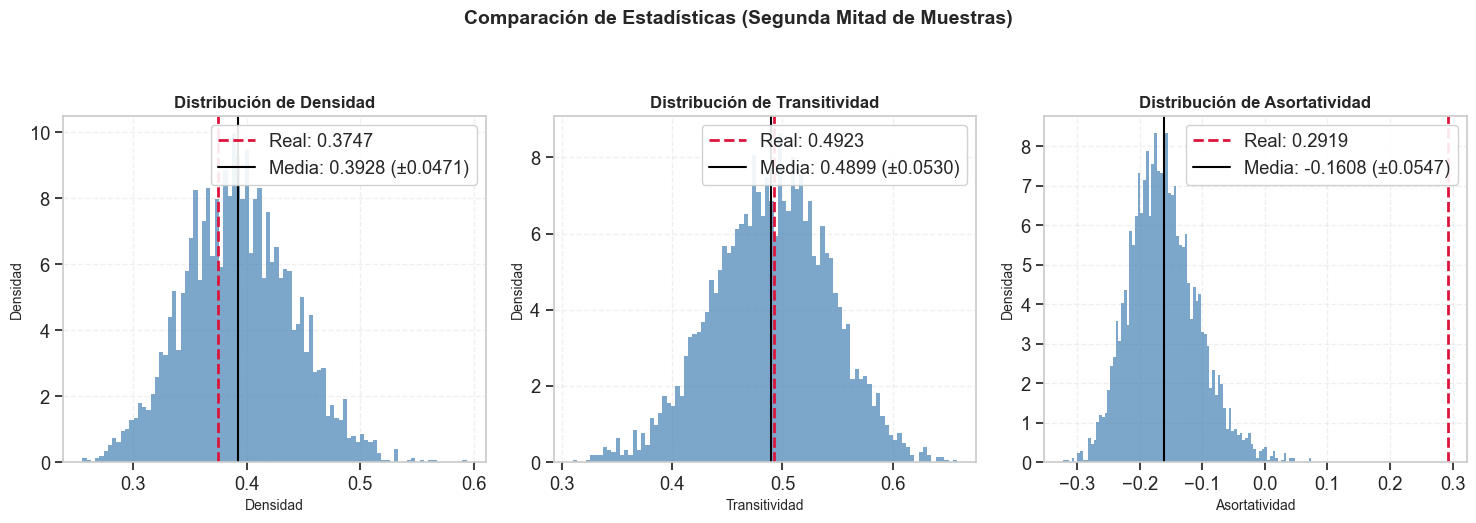


===== RESUMEN DE ESTADÍSTICAS (SEGUNDA MITAD DE MUESTRAS) =====

DENSIDAD:
  Real:              0.3747
  Media Simulada:    0.3928
  Desviación Std:    0.0471
  Error Absoluto:    0.0181
  Error Relativo:    4.83%

TRANSITIVIDAD:
  Real:              0.4923
  Media Simulada:    0.4899
  Desviación Std:    0.0530
  Error Absoluto:    0.0024
  Error Relativo:    0.49%

ASORTATIVIDAD:
  Real:              0.2919
  Media Simulada:    -0.1608
  Desviación Std:    0.0547
  Error Absoluto:    0.4527
  Error Relativo:    155.08%


In [87]:
from typing import Dict, List, Tuple, Any, Optional
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_interaction_matrix(theta_samples: np.ndarray) -> np.ndarray:
    """
    Reconstruye la matriz completa de probabilidades de interacción a partir de muestras.
    
    Args:
        theta_samples: Array de muestras con forma 3D o 4D
        
    Returns:
        Array 3D de matrices de interacción reconstruidas
    """
    # Si es un array 4D (chains, draws, 8, 8), aplanar cadenas y muestras
    if theta_samples.ndim == 4:
        theta_samples = theta_samples.reshape(-1, theta_samples.shape[2], theta_samples.shape[3])
    
    # No es necesario iterar explícitamente, ya que theta_samples ya tiene la forma correcta
    return theta_samples


def safe_assortativity(G: nx.Graph) -> float:
    """
    Cálculo seguro de asortatividad con múltiples métodos de respaldo.
    
    Args:
        G: Grafo de NetworkX
        
    Returns:
        Coeficiente de asortatividad o 0 si no se puede calcular
    """
    try:
        # Primero intentar asortatividad por grado
        assort = nx.degree_assortativity_coefficient(G)
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    try:
        # Intentar asortatividad por atributo aleatorio
        nx.set_node_attributes(G, {n: np.random.random() for n in G.nodes()}, 'random_attr')
        assort = nx.attribute_assortativity_coefficient(G, 'random_attr')
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    return 0  # Valor por defecto si todos los métodos fallan


def generate_networks(
    interaction_matrices: np.ndarray, 
    num_nodes: int, 
    num_blocks: int, 
    networks_per_matrix: int = 2000
) -> List[nx.Graph]:
    """
    Genera múltiples redes basadas en los parámetros muestreados.
    
    Args:
        interaction_matrices: Array de matrices de interacción
        num_nodes: Número de nodos en cada red
        num_blocks: Número de bloques en el modelo
        networks_per_matrix: Número de redes a generar por matriz
        
    Returns:
        Lista de grafos generados
    """
    networks = []
    
    for matrix in interaction_matrices:
        # Generar múltiples redes para cada matriz de interacción
        for _ in range(networks_per_matrix):
            # Simulación de asignación de bloques uniforme
            block_assignments = np.random.randint(0, num_blocks, size=num_nodes)
            
            # Inicializar grafo
            G = nx.Graph()
            G.add_nodes_from(range(num_nodes))
            
            # Generar matriz de adyacencia eficientemente
            edges = []
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    block_i, block_j = block_assignments[i], block_assignments[j]
                    if np.random.random() < matrix[block_i, block_j]:
                        edges.append((i, j))
            
            G.add_edges_from(edges)
            networks.append(G)
    
    return networks


def compute_network_statistics(networks: List[nx.Graph]) -> Dict[str, List[float]]:
    """
    Calcula estadísticas de red: densidad, transitividad, asortatividad.
    
    Args:
        networks: Lista de grafos de NetworkX
        
    Returns:
        Diccionario con estadísticas calculadas
    """
    stats = {
        'densidad': [],
        'transitividad': [],
        'asortatividad': []
    }
    
    for G in networks:
        # Densidad
        stats['densidad'].append(nx.density(G))
        
        # Transitividad con manejo de excepciones
        try:
            transitivity = nx.transitivity(G)
            stats['transitividad'].append(transitivity if not np.isnan(transitivity) else 0)
        except (nx.NetworkXError, ZeroDivisionError):
            stats['transitividad'].append(0)
        
        # Asortatividad
        stats['asortatividad'].append(safe_assortativity(G))
    
    return stats


def plot_statistics_comparison(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float], 
    output_file: Optional[str] = "precision_estMSBSIM1_segunda_mitad.png"
) -> plt.Figure:
    """
    Compara las estadísticas de red generadas con los valores reales.
    
    Args:
        stats: Diccionario con estadísticas calculadas
        real_stats: Diccionario con valores reales de referencia
        output_file: Nombre del archivo para guardar la figura
        
    Returns:
        Figura de matplotlib
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    stat_names = ['densidad', 'transitividad', 'asortatividad']
    
    for i, stat_name in enumerate(stat_names):
        # Filtrar valores NaN
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        # Calcular estadísticas
        posterior_mean = np.mean(valid_stats)
        posterior_std = np.std(valid_stats)
        
        # Histograma con densidad de probabilidad
        axes[i].hist(valid_stats, bins=min(100, len(valid_stats)//50 + 10), 
                    density=True, alpha=0.7, color='steelblue')
        
        # Valor real
        axes[i].axvline(real_stats[stat_name], color='crimson', linestyle='--', linewidth=2,
                       label=f'Real: {real_stats[stat_name]:.4f}')
        
        # Media posterior
        axes[i].axvline(posterior_mean, color='black', linestyle='-', linewidth=1.5,
                       label=f'Media: {posterior_mean:.4f} (±{posterior_std:.4f})')
        
        # Mejorar apariencia
        axes[i].set_title(f'Distribución de {stat_name.capitalize()}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(stat_name.capitalize(), fontsize=10)
        axes[i].set_ylabel('Densidad', fontsize=10)
        axes[i].grid(alpha=0.3, linestyle='--')
        axes[i].legend(loc='best', frameon=True, framealpha=0.9)
    
    plt.suptitle('Comparación de Estadísticas (Segunda Mitad de Muestras)', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    # Guardar figura si se especificó un nombre de archivo
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig


def summarize_statistics(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float]
) -> Dict[str, Dict[str, float]]:
    """
    Genera un resumen de estadísticas comparando valores reales y simulados.
    
    Args:
        stats: Diccionario con estadísticas calculadas
        real_stats: Diccionario con valores reales de referencia
        
    Returns:
        Diccionario con resumen de estadísticas
    """
    summary = {}
    
    for stat_name in ['densidad', 'transitividad', 'asortatividad']:
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        summary[stat_name] = {
            'real': real_stats[stat_name],
            'media': np.mean(valid_stats),
            'desv_std': np.std(valid_stats),
            'mediana': np.median(valid_stats),
            'error_abs': abs(real_stats[stat_name] - np.mean(valid_stats)),
            'error_rel': abs(real_stats[stat_name] - np.mean(valid_stats)) / (abs(real_stats[stat_name]) + 1e-10) * 100
        }
    
    return summary


def main():
    # Parámetros reales
    real_stats = {
        'densidad': 0.3747,
        'transitividad': 0.4923,
        'asortatividad': 0.2919
    }

    # Reconstrucción de matrices
    theta_samples = trace_hier.posterior['Theta_kl'].values
    
    # Determinar el punto medio para tomar solo la segunda mitad
    # Adaptado para manejar arrays de 3 dimensiones (samples, blocks, blocks)
    midpoint = theta_samples.shape[0] // 2
    second_half_samples = theta_samples[midpoint:, :, :]
    
    interaction_matrices = reconstruct_interaction_matrix(second_half_samples)

    print(f"Análisis con la segunda mitad de muestras:")
    print(f"- Total de muestras original: {theta_samples.shape[0]}")
    print(f"- Muestras utilizadas: {second_half_samples.shape[0]}")
    print(f"- Dimensiones de matrices de interacción: {interaction_matrices.shape}")

    # Generar redes
    print("Generando redes...")
    networks = generate_networks(
        interaction_matrices, 
        num_nodes=50, 
        num_blocks=8, 
        networks_per_matrix=2000
    )
    print(f"Se generaron {len(networks)} redes para el análisis")

    # Cálculo de estadísticas
    print("Calculando estadísticas de red...")
    network_stats = compute_network_statistics(networks)

    # Visualización de comparación
    print("Generando visualizaciones...")
    fig = plot_statistics_comparison(network_stats, real_stats)
    plt.savefig("presiMultSim2.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Resumen de estadísticas
    summary = summarize_statistics(network_stats, real_stats)
    
    print("\n===== RESUMEN DE ESTADÍSTICAS (SEGUNDA MITAD DE MUESTRAS) =====")
    for stat_name, values in summary.items():
        print(f"\n{stat_name.upper()}:")
        print(f"  Real:              {values['real']:.4f}")
        print(f"  Media Simulada:    {values['media']:.4f}")
        print(f"  Desviación Std:    {values['desv_std']:.4f}")
        print(f"  Error Absoluto:    {values['error_abs']:.4f}")
        print(f"  Error Relativo:    {values['error_rel']:.2f}%")


if __name__ == "__main__":
    main()

##CONVERGENCIA DE GAMMA

Shape of gamma_samples: (40000, 5)

Superblock Assignments (Natural Clustering):
Superblock 1: 2 blocks - [2, 4]
Superblock 2: 2 blocks - [3, 5]
Superblock 3: 1 blocks - [1]


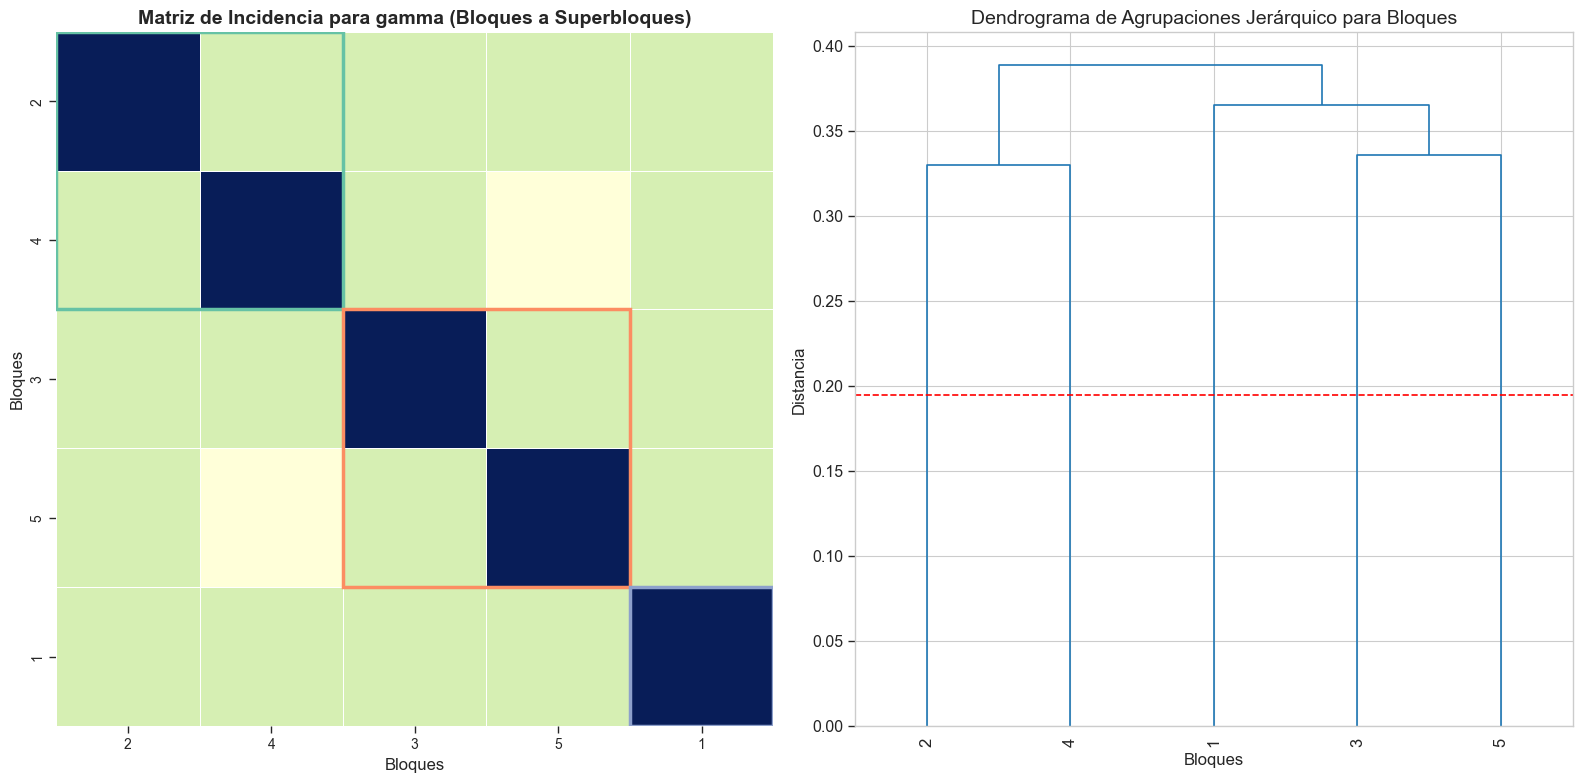

In [15]:
# Extraer muestras de gamma_row
gamma_samples = trace_hier.posterior["gamma_row"].values
gamma_samples = gamma_samples.reshape(-1, 5)  # (total_samples, num_blocks=5)
num_samples = gamma_samples.shape[0]
num_blocks = gamma_samples.shape[1]  # 5 bloques
num_superblocks = 3  # Según lo especificado

print(f"Shape of gamma_samples: {gamma_samples.shape}")

# Calcular matriz de co-ocurrencia (cuántas veces aparecen dos bloques en el mismo superbloque)
gamma_cooccurrence = np.zeros((num_blocks, num_blocks))
for sample in gamma_samples:
    for i in range(num_blocks):
        for j in range(num_blocks):
            if sample[i] == sample[j]:
                gamma_cooccurrence[i, j] += 1

# Normalizar por número de muestras
gamma_cooccurrence = gamma_cooccurrence / num_samples

# Mejorar el contraste para visualización usando una función no lineal
gamma_enhanced = np.tanh(3 * gamma_cooccurrence)
gamma_enhanced = np.round(gamma_enhanced, 2)

# Aplicar clustering jerárquico para determinar el orden de bloques
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

# Convertir la matriz de similitud a matriz de distancia
distance_matrix = 1 - gamma_cooccurrence
# Convertir a formato condensado para el clustering jerárquico
condensed_dist = squareform(distance_matrix)
# Realizar clustering jerárquico
Z = linkage(condensed_dist, method='ward')
# Extraer las etiquetas de cluster a nivel num_superblocks
cluster_labels = fcluster(Z, num_superblocks, criterion='maxclust') - 1

# Ordenar bloques por etiqueta de cluster y luego por índice dentro del cluster
sorted_indices = np.lexsort((np.arange(num_blocks), cluster_labels))
block_indices = np.arange(num_blocks) + 1  # Bloques numerados desde 1

# Crear resumen de asignaciones
cluster_summary = {}
for cluster in range(num_superblocks):
    blocks_in_cluster = block_indices[cluster_labels == cluster]
    cluster_summary[f"Superblock {cluster+1}"] = {
        "Blocks": blocks_in_cluster.tolist(),
        "Count": len(blocks_in_cluster)
    }

print("\nSuperblock Assignments (Natural Clustering):")
for cluster, info in cluster_summary.items():
    print(f"{cluster}: {info['Count']} blocks - {info['Blocks']}")

# Reordenar la matriz según el clustering
gamma_sorted = gamma_enhanced[np.ix_(sorted_indices, sorted_indices)]

# Crear DataFrame y guardar
df_sorted = pd.DataFrame(
    gamma_sorted,
    index=block_indices[sorted_indices],
    columns=block_indices[sorted_indices]
)
df_sorted.to_csv("incidGammaSBM_Natural.csv", index=True, header=True)

# Crear una figura con dos subplots lado a lado
fig = plt.figure(figsize=(16, 8))

# Primer subplot para la matriz de incidencia (sin barra de color)
ax1 = fig.add_subplot(1, 2, 1)
elegant_cmap = sns.color_palette("YlGnBu", as_cmap=True)

# Plotear heatmap sin la barra de color (cbar=False)
sns.heatmap(df_sorted, cmap=elegant_cmap, cbar=False,
            linewidths=0.5, linecolor='white', ax=ax1)
ax1.set_title("Matriz de Incidencia para gamma (Bloques a Superbloques)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Bloques", fontsize=12)
ax1.set_ylabel("Bloques", fontsize=12)
ax1.tick_params(labelsize=10)

# Añadir límites de superbloques
current_pos = 0
elegant_boundary_palette = sns.color_palette("Set2", num_superblocks)
for cluster in range(num_superblocks):
    # Contar cuántos bloques hay en este cluster después del ordenamiento
    cluster_size = np.sum(cluster_labels[sorted_indices] == cluster)
    if cluster_size > 0:
        ax1.add_patch(plt.Rectangle((current_pos, current_pos),
                                    cluster_size, cluster_size,
                                    fill=False, edgecolor=elegant_boundary_palette[cluster],
                                    lw=2.5, linestyle='-'))
        current_pos += cluster_size

# Segundo subplot para el dendrograma
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(Z, labels=block_indices, leaf_rotation=90, ax=ax2)
ax2.set_title('Dendrograma de Agrupaciones Jerárquico para Bloques', fontsize=14)
ax2.set_xlabel('Bloques', fontsize=12)
ax2.set_ylabel('Distancia', fontsize=12)
ax2.axhline(y=max(Z[:, 2])/2, color='r', linestyle='--')  # Línea para corte en 3 clusters

plt.tight_layout()
plt.savefig("incidencia_y_dendrograma.png", dpi=300, bbox_inches='tight')
plt.show()

Shape of gamma_samples: (20000, 5)
Usando 20000 muestras (segunda mitad de las cadenas)

Superblock Assignments (Natural Clustering):
Superblock 1: 2 blocks - [3, 5]
Superblock 2: 2 blocks - [2, 4]
Superblock 3: 1 blocks - [1]


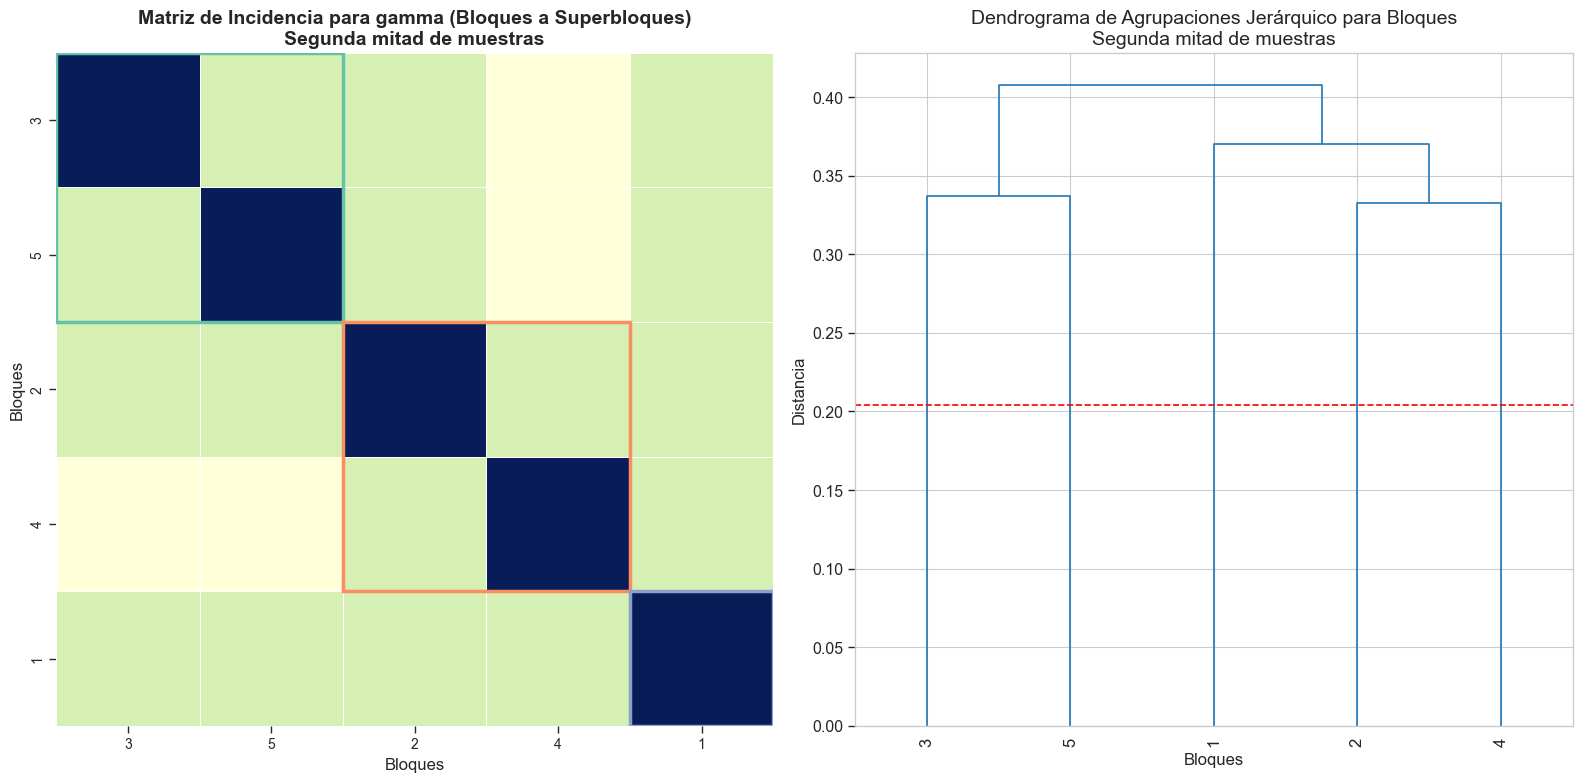

In [53]:
# Extraer muestras de gamma_row (usando solo la segunda mitad)
gamma_samples = trace_hier.posterior["gamma_row"].values
total_samples_per_chain = gamma_samples.shape[1]
# Seleccionar solo la segunda mitad de las muestras en cada cadena
second_half_idx = total_samples_per_chain // 2
gamma_samples = gamma_samples[:, second_half_idx:, :]
# Aplanar las muestras para el análisis
gamma_samples = gamma_samples.reshape(-1, 5)  # (total_samples, num_blocks=5)
num_samples = gamma_samples.shape[0]
num_blocks = gamma_samples.shape[1]  # 5 bloques
num_superblocks = 3  # Según lo especificado

print(f"Shape of gamma_samples: {gamma_samples.shape}")
print(f"Usando {num_samples} muestras (segunda mitad de las cadenas)")

# Calcular matriz de co-ocurrencia (cuántas veces aparecen dos bloques en el mismo superbloque)
gamma_cooccurrence = np.zeros((num_blocks, num_blocks))
for sample in gamma_samples:
    for i in range(num_blocks):
        for j in range(num_blocks):
            if sample[i] == sample[j]:
                gamma_cooccurrence[i, j] += 1

# Normalizar por número de muestras
gamma_cooccurrence = gamma_cooccurrence / num_samples

# Mejorar el contraste para visualización usando una función no lineal
gamma_enhanced = np.tanh(3 * gamma_cooccurrence)
gamma_enhanced = np.round(gamma_enhanced, 2)

# Aplicar clustering jerárquico para determinar el orden de bloques
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

# Convertir la matriz de similitud a matriz de distancia
distance_matrix = 1 - gamma_cooccurrence
# Convertir a formato condensado para el clustering jerárquico
condensed_dist = squareform(distance_matrix)
# Realizar clustering jerárquico
Z = linkage(condensed_dist, method='ward')
# Extraer las etiquetas de cluster a nivel num_superblocks
cluster_labels = fcluster(Z, num_superblocks, criterion='maxclust') - 1

# Ordenar bloques por etiqueta de cluster y luego por índice dentro del cluster
sorted_indices = np.lexsort((np.arange(num_blocks), cluster_labels))
block_indices = np.arange(num_blocks) + 1  # Bloques numerados desde 1

# Crear resumen de asignaciones
cluster_summary = {}
for cluster in range(num_superblocks):
    blocks_in_cluster = block_indices[cluster_labels == cluster]
    cluster_summary[f"Superblock {cluster+1}"] = {
        "Blocks": blocks_in_cluster.tolist(),
        "Count": len(blocks_in_cluster)
    }

print("\nSuperblock Assignments (Natural Clustering):")
for cluster, info in cluster_summary.items():
    print(f"{cluster}: {info['Count']} blocks - {info['Blocks']}")

# Reordenar la matriz según el clustering
gamma_sorted = gamma_enhanced[np.ix_(sorted_indices, sorted_indices)]

# Crear DataFrame y guardar
import pandas as pd
df_sorted = pd.DataFrame(
    gamma_sorted,
    index=block_indices[sorted_indices],
    columns=block_indices[sorted_indices]
)
df_sorted.to_csv("incidGammaSBM_Natural_SecondHalf.csv", index=True, header=True)

# Crear una figura con dos subplots lado a lado
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize=(16, 8))

# Primer subplot para la matriz de incidencia (sin barra de color)
ax1 = fig.add_subplot(1, 2, 1)
elegant_cmap = sns.color_palette("YlGnBu", as_cmap=True)

# Plotear heatmap sin la barra de color (cbar=False)
sns.heatmap(df_sorted, cmap=elegant_cmap, cbar=False,
            linewidths=0.5, linecolor='white', ax=ax1)
ax1.set_title("Matriz de Incidencia para gamma (Bloques a Superbloques)\nSegunda mitad de muestras", fontsize=14, fontweight='bold')
ax1.set_xlabel("Bloques", fontsize=12)
ax1.set_ylabel("Bloques", fontsize=12)
ax1.tick_params(labelsize=10)

# Añadir límites de superbloques
current_pos = 0
elegant_boundary_palette = sns.color_palette("Set2", num_superblocks)
for cluster in range(num_superblocks):
    # Contar cuántos bloques hay en este cluster después del ordenamiento
    cluster_size = np.sum(cluster_labels[sorted_indices] == cluster)
    if cluster_size > 0:
        ax1.add_patch(plt.Rectangle((current_pos, current_pos),
                                    cluster_size, cluster_size,
                                    fill=False, edgecolor=elegant_boundary_palette[cluster],
                                    lw=2.5, linestyle='-'))
        current_pos += cluster_size

# Segundo subplot para el dendrograma
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(Z, labels=block_indices, leaf_rotation=90, ax=ax2)
ax2.set_title('Dendrograma de Agrupaciones Jerárquico para Bloques\nSegunda mitad de muestras', fontsize=14)
ax2.set_xlabel('Bloques', fontsize=12)
ax2.set_ylabel('Distancia', fontsize=12)
ax2.axhline(y=max(Z[:, 2])/2, color='r', linestyle='--')  # Línea para corte en 3 clusters

plt.tight_layout()
plt.savefig("incidencia_y_dendrograma_SecondHalf.png", dpi=300, bbox_inches='tight')
plt.show()

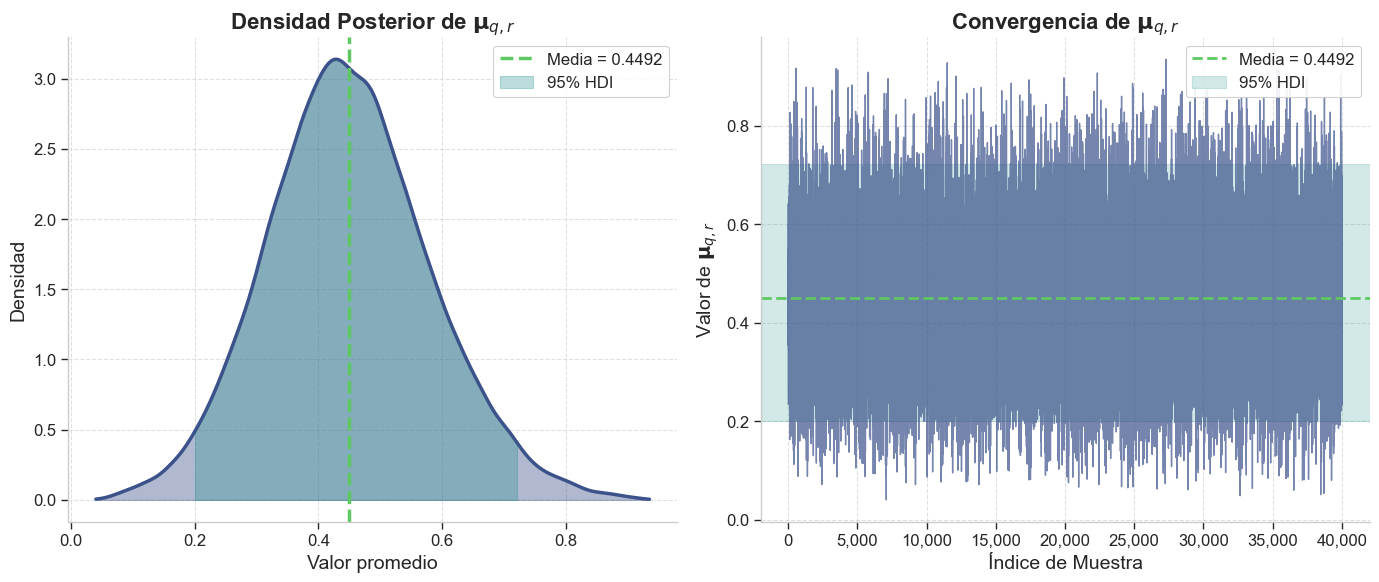

          Estadística     Valor
     Promedio de Mean     0.449
       Promedio de SD     0.131
   Promedio de HDI 3%     0.212
  Promedio de HDI 97%     0.711
Promedio de MCSE Mean     0.001
  Promedio de MCSE SD     0.001
 Promedio de ESS Bulk 14934.000
 Promedio de ESS Tail 13593.000
    Promedio de R hat     1.000


In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import gaussian_kde
import arviz as az
import pandas as pd

# Configuración estética
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
colors = sns.color_palette("viridis", 3)

# Extraer los datos de mu_qr del trace
mu_qr_samples = trace_hier.posterior['mu_qr'].values
mu_qr_samples_flattened = mu_qr_samples.reshape(-1, mu_qr_samples.shape[-1])
mu_qr_means_per_sample = mu_qr_samples_flattened.mean(axis=1)

# Calcular la media global
mean_value = mu_qr_means_per_sample.mean()

# Calcular la densidad de kernel (KDE)
kde = gaussian_kde(mu_qr_means_per_sample)
x_vals = np.linspace(mu_qr_means_per_sample.min(), mu_qr_means_per_sample.max(), 1000)
y_vals = kde(x_vals)

# Crear la figura con dos subgráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white')

# Gráfica de densidad (izquierda)
ax[0].plot(x_vals, y_vals, color=colors[0], linewidth=2.5)
ax[0].fill_between(x_vals, y_vals, color=colors[0], alpha=0.4)
ax[0].axvline(mean_value, color=colors[2], linestyle='--', linewidth=2.5, 
            label=f'Media = {mean_value:.4f}')

# Agregar sombreado para el intervalo HDI (95%)
lower_idx = np.searchsorted(x_vals, np.percentile(mu_qr_means_per_sample, 2.5))
upper_idx = np.searchsorted(x_vals, np.percentile(mu_qr_means_per_sample, 97.5))
ax[0].fill_between(x_vals[lower_idx:upper_idx], y_vals[lower_idx:upper_idx], 
                   color=colors[1], alpha=0.3,
                   label='95% HDI')

# Mejoras en la gráfica de densidad
# Mejoras en la gráfica de densidad
ax[0].set_title(r'Densidad Posterior de $\mathbf{\mu}_{q,r}$', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Valor promedio', fontsize=14)
ax[0].set_ylabel('Densidad', fontsize=14)
ax[0].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# Gráfica de traza (derecha)
ax[1].plot(mu_qr_means_per_sample, color=colors[0], alpha=0.7, linewidth=1.0)
ax[1].axhline(y=mean_value, color=colors[2], linestyle='--', linewidth=2, 
             label=f'Media = {mean_value:.4f}')

# Sombreado para visualizar la variación
upper_bound = np.percentile(mu_qr_means_per_sample, 97.5)
lower_bound = np.percentile(mu_qr_means_per_sample, 2.5)
ax[1].axhspan(lower_bound, upper_bound, alpha=0.2, color=colors[1], label='95% HDI')

# Mejoras en la gráfica de traza
# Mejoras en la gráfica de traza
ax[1].set_title(r'Convergencia de $\mathbf{\mu}_{q,r}$', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Índice de Muestra', fontsize=14)
ax[1].set_ylabel(r'Valor de $\mathbf{\mu}_{q,r}$', fontsize=14)
ax[1].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12, loc='upper right')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Formatear los valores de los ejes para mayor legibilidad
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Ajustes finales
plt.tight_layout()
plt.savefig("convMuQrSIMUL2MULTI.png", dpi=300, bbox_inches="tight")
plt.show()

# Análisis estadístico adicional
mu_qr_samples = trace_hier.posterior['mu_qr'].values
mu_qr_means_per_chain = mu_qr_samples.mean(axis=-1)  # (chains, draws)

# Convertir a xarray
mu_qr_means_xr = xr.DataArray(
    mu_qr_means_per_chain,
    dims=["chain", "draw"],
    name="mu_qr_mean"
)

inference_data = az.from_dict(posterior={"mu_qr_mean": mu_qr_means_xr})

# Obtener resumen completo
summary_df = az.summary(inference_data, var_names=["mu_qr_mean"], hdi_prob=0.94)

# Extraer estadísticas de interés
stats = {
    "Promedio de Mean": summary_df["mean"].values[0],
    "Promedio de SD": summary_df["sd"].values[0],
    "Promedio de HDI 3%": summary_df["hdi_3%"].values[0],
    "Promedio de HDI 97%": summary_df["hdi_97%"].values[0],
    "Promedio de MCSE Mean": summary_df["mcse_mean"].values[0],
    "Promedio de MCSE SD": summary_df["mcse_sd"].values[0],
    "Promedio de ESS Bulk": summary_df["ess_bulk"].values[0],
    "Promedio de ESS Tail": summary_df["ess_tail"].values[0],
    "Promedio de R hat": summary_df["r_hat"].values[0],
}

# Convertir a DataFrame para presentación bonita
tabla_estadisticas = pd.DataFrame({
    "Estadística": list(stats.keys()),
    "Valor": [round(v, 4) for v in stats.values()]
})

print(tabla_estadisticas.to_string(index=False))